# **Time Series Regression Analysis**

## Business Understanding

Corporacion Favorita is an Ecuador based company engaged in the organization, installation and administration of stores, markets and supermarkets. The business areas in which the organization is involved are Commercial area, Real estate area and Industrial area. The company aims to optimize its inventory management by accurately forecasting the product demand in various locations.
By accurate demand forecasting, the company will be able to maintain optimal inventory levels, reduce wastage by aligning it supply with the customers demand, the company can enhance customer satisfaction, increase their sales revenue and reduce their carrying costs.

The key stakeholders are the Inventory managers, supply chain managers, and store managers who will rely on the model of this project to make informed decisions related to purchasing, replenishment, and stock allocation.

The objective of the project is to develop machine learning models to forecast the demand for products in various store locations of Corporation Favorita

# **Data Understanding**

### Train.csv
The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
store_nbr identifies the store at which the products are sold.
family identifies the type of product sold.
sales give the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.
### Test.csv
The test data, having the same features as the training data. That  will be used to predict the target sales for the dates in this file.
The dates in the test data are for the 15 days after the last date in the training data.
### Transaction.csv
Contains date, store_nbr and transaction made on that specific date.
sample_submission.csv
A sample submission file in the correct format.
### Stores.csv
Store metadata, including city, state, type, and cluster.
Cluster is a grouping of similar stores.
### Oil.csv
Daily oil price which includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and its economical health is highly vulnerable to shocks in oil prices.)
### Holidays_events.csv
Holidays and Events, with metadata


# Hypothesis

Null Hypothesis: Promotions do not have a positive impact on overall sales.

Alternate Hypothesis: Promotions have a positive impact on overall sales.


# Analytical Questions:

1.Is the train dataset complete (has all the required dates)?

2.Which dates have the lowest and highest sales for each year (excluding days the store was closed)?

3.Compare the sales for each month across the years and determine which month of which year had the highest sales.

4.Did the earthquake impact sales?

5.Are certain stores or groups of stores selling more products? (Cluster, city, state, type)

6.Are sales affected by promotions, oil prices and holidays?

7.What analysis can we get from the date and its extractable features?

8.Which product family and stores did the promotions affect.

9.What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

10.Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.

In [1]:
%pip install pyodbc 
%pip install python-dotenv 
%pip install plotly
%pip install statsmodels
%pip install pmdarima
! pip install xgboost




Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.




[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pyodbc
from dotenv import dotenv_values
import pandas as pd
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
import numpy as np
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error,mean_squared_log_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder,MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from scipy.stats import uniform, randint
from sklearn.metrics import make_scorer

warnings.filterwarnings("ignore")

In [3]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')

# Get the values for the credentials you set in the '.env' file
server = environment_variables.get("server")
database = environment_variables.get("database")
username = environment_variables.get("username")
password = environment_variables.get("password")


In [4]:
# Create a connection string
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password};MARS_Connection=yes;MinProtocolVersion=TLSv1.2;"

In [5]:
connection = pyodbc.connect(connection_string)

In [6]:
query = "SELECT * FROM dbo.oil"

oil_data = pd.read_sql(query, connection)
oil_data.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [7]:
query = "SELECT * FROM dbo.holidays_events"

holidays_events_data = pd.read_sql(query, connection)
holidays_events_data.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [8]:
query = "SELECT * FROM dbo.stores"

stores_data = pd.read_sql(query, connection)
stores_data.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [9]:
# load transaction data
transaction_data= pd.read_csv(r'C:\Users\HP\OneDrive\Desktop\Github projects\Time-Series-Regression-Analysis\datasets\transactions.csv')
transaction_data.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [10]:
# load train data
train_data= pd.read_csv(r'C:\Users\HP\OneDrive\Desktop\Github projects\Time-Series-Regression-Analysis\datasets\train.csv')
train_data.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


# EDA

### Train data

In [11]:
train_data.tail()

,id,date,store_nbr,family,sales,onpromotion
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0


In [12]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [13]:
train_data.shape

(3000888, 6)

In [14]:
# # Check for missing values in train_data
train_data.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [15]:
# Check for duplicates in train_data
train_data.duplicated().sum()

0

In [16]:
train_data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,3000888.0,NaN,NaN,NaN,1500443.5,866281.891642,0.0,750221.75,1500443.5,2250665.25,3000887.0
date,3000888,1684,2013-01-01,1782,NaN,NaN,NaN,NaN,NaN,NaN,NaN
store_nbr,3000888.0,NaN,NaN,NaN,27.5,15.585787,1.0,14.0,27.5,41.0,54.0
family,3000888,33,AUTOMOTIVE,90936,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sales,3000888.0,NaN,NaN,NaN,357.775749,1101.997721,0.0,0.0,11.0,195.84725,124717.0
onpromotion,3000888.0,NaN,NaN,NaN,2.60277,12.218882,0.0,0.0,0.0,0.0,741.0


In [17]:
# checking unique family names
train_data['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [18]:
train_data['date'] = pd.to_datetime(train_data['date'])

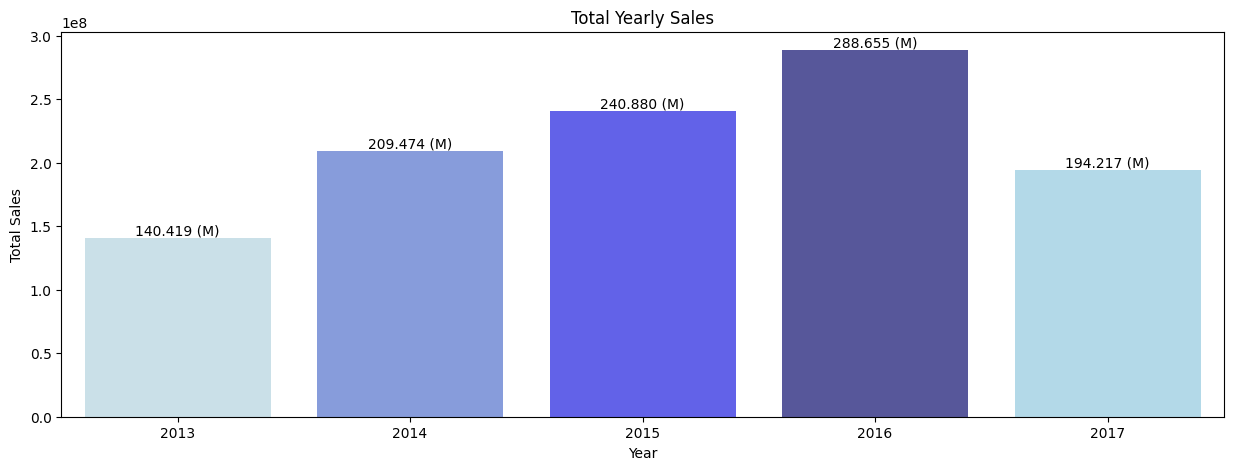

In [19]:
# Copy the train data
train_data_cp = train_data.copy()

# Extracting year from the 'date' column and setting it as index
train_data_cp.set_index(train_data_cp['date'].dt.year, inplace=True)
train_data_cp.index.name = 'year'  # Naming the index as 'year'

# Grouping by year and summing the sales
total_yearly_sales = train_data_cp.groupby('year')['sales'].sum()
# Plotting the total yearly sales with a bar plot
custom_palette = ['lightblue', 'royalblue', 'blue', 'navy', 'skyblue']
plt.figure(figsize=(15,5))
barplot = sns.barplot(x=total_yearly_sales.index, y=total_yearly_sales.values, palette=custom_palette, alpha=0.7)
for index, value in enumerate(total_yearly_sales):
    label = f'{value /1e6:.3f} (M)'  # Format value in Millions
    barplot.text(index, value, label, ha='center', va='bottom')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.title('Total Yearly Sales')
plt.show()

#### Findings

- Sales increased every year from 2013 to 2016.
- 2013 had the lowest sales at 140.419 million.
- After reaching a peak in 2016, sales decreased in 2017.


### items on promotion by family

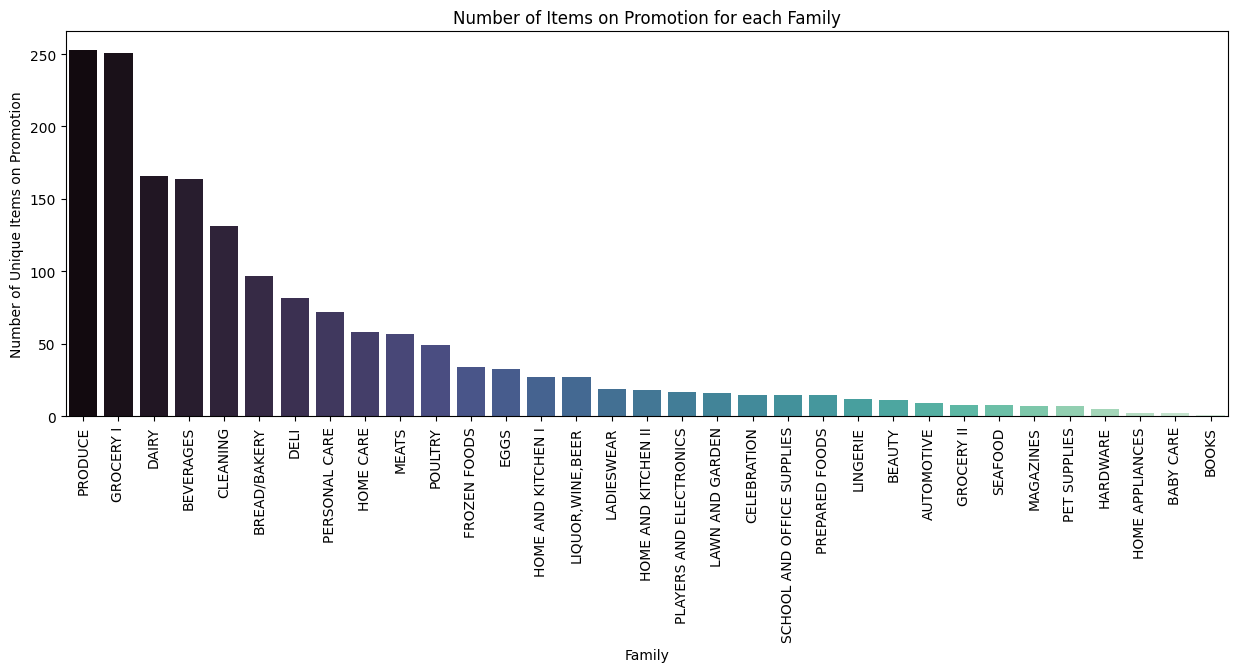

In [20]:
# Plot number of unique items on promotion for each family
plt.figure(figsize=(15,5))
data = train_data.groupby('family')['onpromotion'].nunique().sort_values(ascending=False)
ax = sns.barplot(data, palette='mako')
plt.title('Number of Items on Promotion for each Family')
plt.xlabel('Family')
plt.ylabel('Number of Unique Items on Promotion')
plt.xticks(rotation=90)
plt.show()

#### Findings
- Produce and Grocery I have the highest number of items on promotion, both with over 250 items. 
- Baby Care, and Books have the least number of items on promotion.

### sales by family

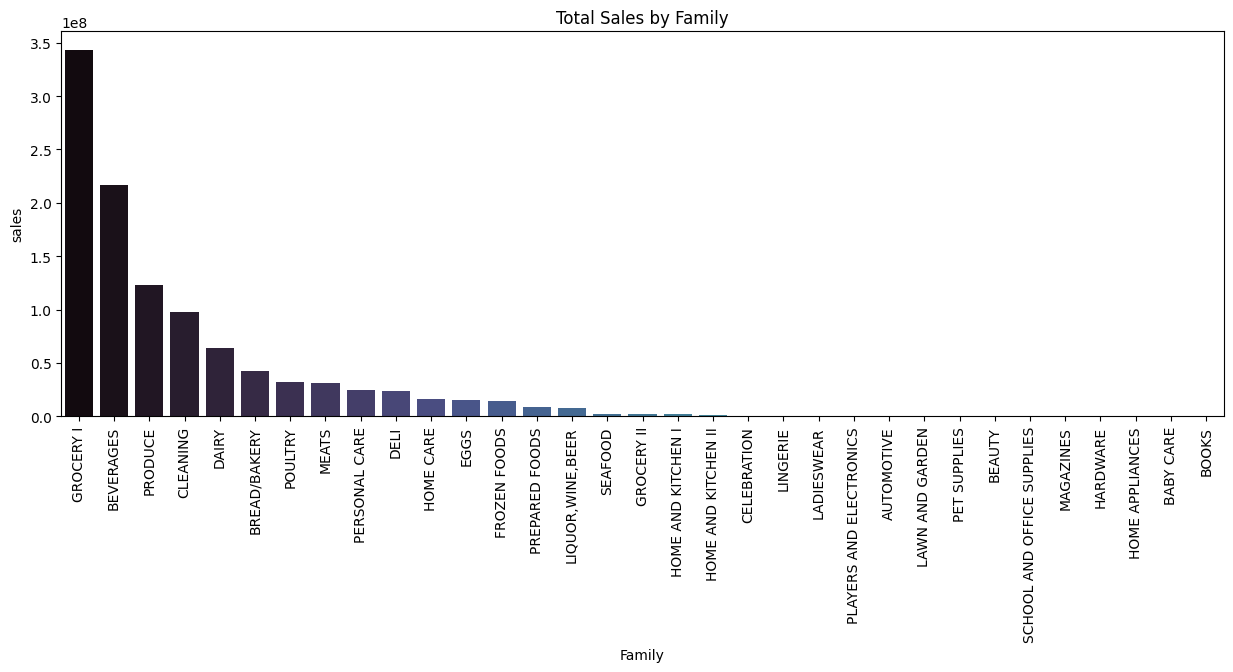

In [21]:
# plot total sales for each family
plt.figure(figsize=(15,5))
train_data_cp_promotion = (train_data_cp.groupby('family')['sales'].sum()).sort_values(ascending=False)
ax = sns.barplot(train_data_cp_promotion, palette='mako')
plt.title('Total Sales by Family')
plt.xlabel('Family')
plt.xticks(rotation=90)
plt.show()

### sales by store_nbr

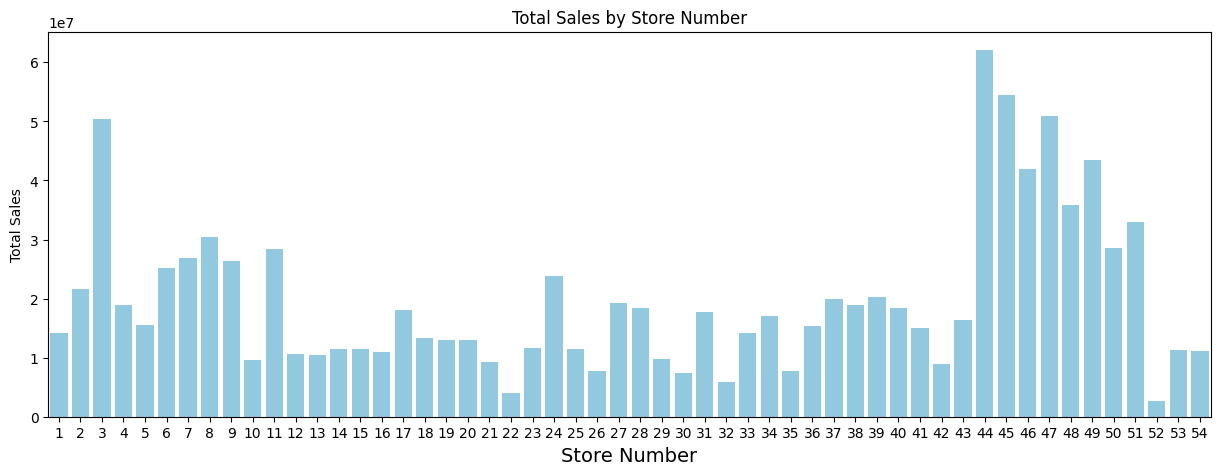

In [22]:
# Grouping by store and summing the sales
total_yearly_sales = train_data_cp.groupby('store_nbr')['sales'].sum()

# Plotting the total yearly sales with a bar plot
plt.figure(figsize=(15,5))
barplot = sns.barplot(x=total_yearly_sales.index, y=total_yearly_sales.values, color='skyblue', alpha=1)
plt.xlabel('Store Number', fontsize=14)
plt.ylabel('Total Sales')
plt.title('Total Sales by Store Number')
plt.show()

# Stores data

In [23]:
stores_data.tail()

,store_nbr,city,state,type,cluster
49,50,Ambato,Tungurahua,A,14
50,51,Guayaquil,Guayas,A,17
51,52,Manta,Manabi,A,11
52,53,Manta,Manabi,D,13
53,54,El Carmen,Manabi,C,3


In [24]:
stores_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [25]:
stores_data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
store_nbr,54.0,NaN,NaN,NaN,27.5,15.732133,1.0,14.25,27.5,40.75,54.0
city,54,22,Quito,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
state,54,16,Pichincha,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
type,54,5,D,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cluster,54.0,NaN,NaN,NaN,8.481481,4.693395,1.0,4.0,8.5,13.0,17.0


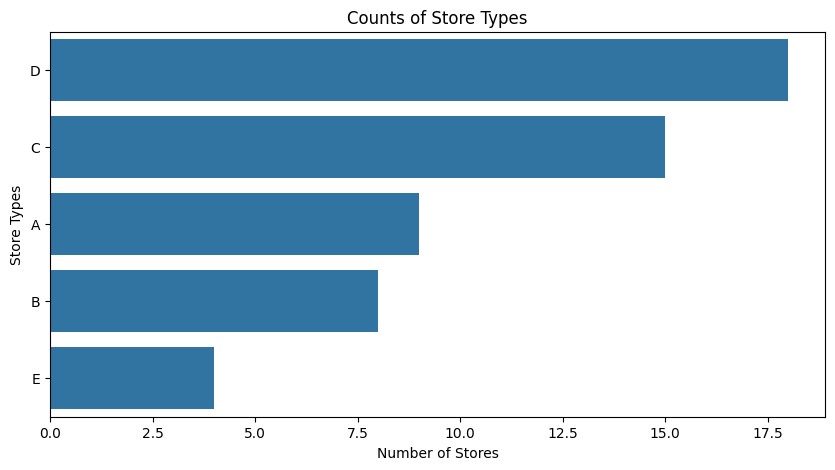

In [26]:
# Compute counts of each store type
stores = stores_data['type'].value_counts()

# Visualization
plt.figure(figsize=(10, 5))

sns.barplot(x=stores.values, y=stores.index)
plt.title('Counts of Store Types')
plt.ylabel('Store Types')
plt.xlabel("Number of Stores")
plt.show()

This indicates that Type D stores are the most common, while Type E stores are the least common.

#### Store number by cities

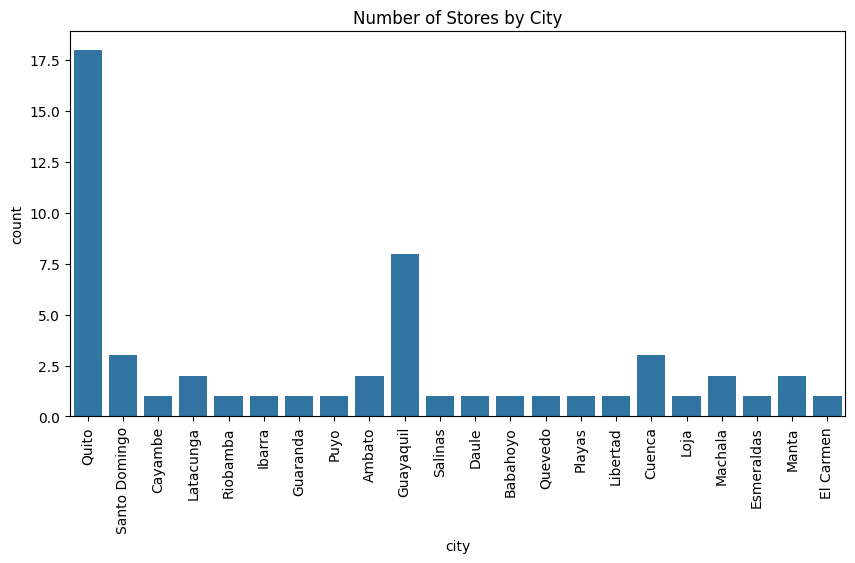

In [27]:
plt.figure(figsize=(10, 5))
sns.countplot(data=stores_data, x='city')
plt.xticks(rotation=90)
plt.title('Number of Stores by City')
plt.show()

#### Distribution of cluster

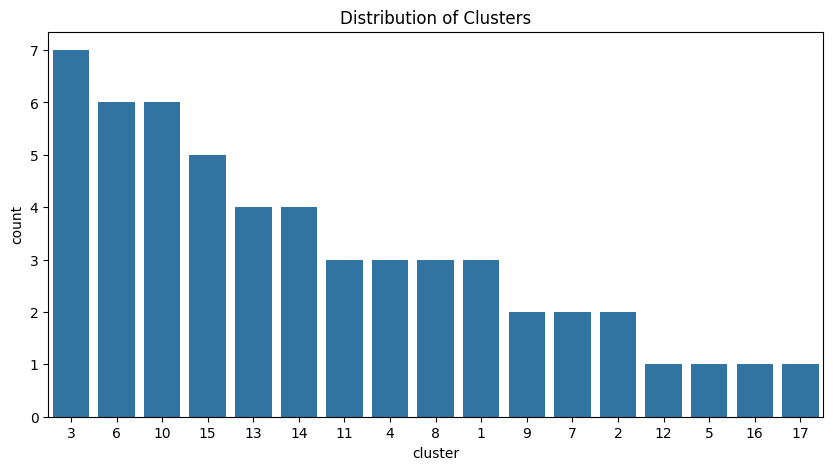

In [28]:
# Distribution of clusters
plt.figure(figsize=(10, 5))

# Order the clusters based on their counts (from highest to lowest)
order = stores_data['cluster'].value_counts().index

sns.countplot(data=stores_data, x='cluster',order=order)
plt.title('Distribution of Clusters')
plt.show()

- cluster is grouping of similar stores 
- cluster 3 has the highest number of similar stores

# oil data

In [29]:
oil_data.tail()

,date,dcoilwtico
1213,2017-08-25,47.650002
1214,2017-08-28,46.400002
1215,2017-08-29,46.459999
1216,2017-08-30,45.959999
1217,2017-08-31,47.259998


In [30]:
oil_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [31]:
oil_data.isnull().sum()

date           0
dcoilwtico    43
dtype: int64

There are 43 missing values in dcoilwtico column

In [32]:
total_rows = len(oil_data)
null_rows = oil_data['dcoilwtico'].isnull().sum()

percentage_null = (null_rows / total_rows) * 100
print(f"Percentage of null values in 'dcoilwtico' column: {percentage_null:.2f}%")

Percentage of null values in 'dcoilwtico' column: 3.53%


In [33]:
oil_data.describe().T

,count,mean,std,min,25%,50%,75%,max
dcoilwtico,1175.0,67.714366,25.630476,26.190001,46.405001,53.189999,95.66,110.620003


#### Oil price vc time

In [34]:
# Creating a line plot using plotly.express
fig = px.line(oil_data, x='date', y='dcoilwtico', title='Oil Prices Over Time')
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Oil Price')
fig.show()

#### distribution of oil prices

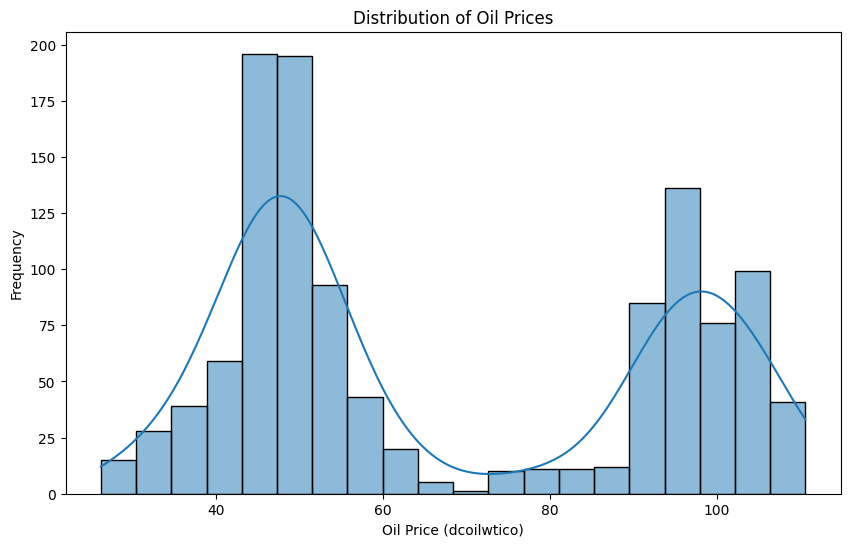

In [35]:
plt.figure(figsize=(10, 6))
sns.histplot(data=oil_data, x='dcoilwtico', bins=20, kde=True)
plt.title("Distribution of Oil Prices")
plt.xlabel("Oil Price (dcoilwtico)")
plt.ylabel("Frequency")
plt.show()

The peak is highest around $40 and $60, it means oil prices were most commonly around here.

# holiday data

In [36]:
holidays_events_data.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [37]:
holidays_events_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [38]:
# Unique holiday events
holidays_events_data['locale'].unique()

array(['Local', 'Regional', 'National'], dtype=object)

In [39]:
# unique locale_name
holidays_events_data['locale_name'].unique()

array(['Manta', 'Cotopaxi', 'Cuenca', 'Libertad', 'Riobamba', 'Puyo',
       'Guaranda', 'Imbabura', 'Latacunga', 'Machala', 'Santo Domingo',
       'El Carmen', 'Cayambe', 'Esmeraldas', 'Ecuador', 'Ambato',
       'Ibarra', 'Quevedo', 'Santo Domingo de los Tsachilas',
       'Santa Elena', 'Quito', 'Loja', 'Salinas', 'Guayaquil'],
      dtype=object)

In [40]:
# unique locale_name
holidays_events_data['type'].unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

In [41]:
holidays_events_data.duplicated().sum()

0

In [42]:
holidays_events_data.drop(columns=['description'], inplace=True)

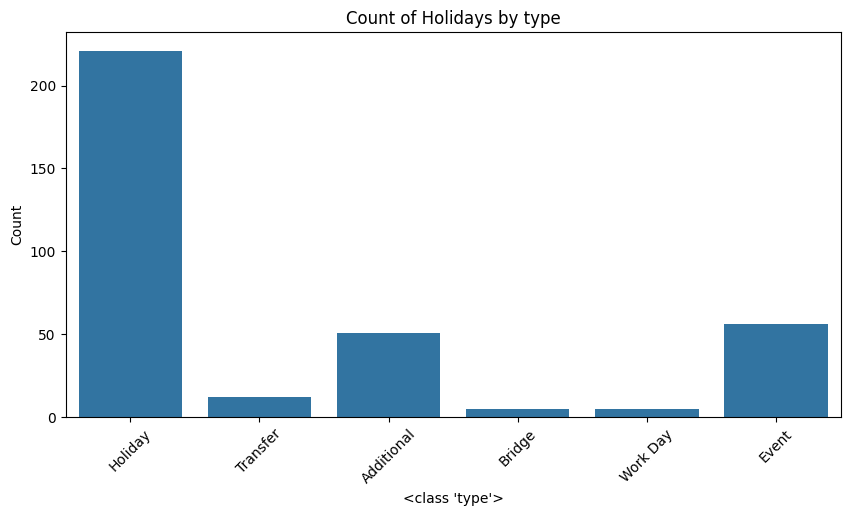

In [43]:
plt.figure(figsize=(10,5))
sns.countplot(data=holidays_events_data, x='type')
plt.title(f'Count of Holidays by type')
plt.xlabel(type)
plt.ylabel('Count')
plt.xticks(rotation=45)  
plt.show()

In [44]:
transaction_data.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [45]:
transaction_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


In [46]:
transaction_data['date']=pd.to_datetime(transaction_data['date'])

In [47]:
transactions_date = transaction_data.groupby('date').transactions.sum().reset_index()
transactions_date = transactions_date.set_index("date")

fig = px.line(transactions_date, title='Transactions Over Time')
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Number of transactions')
fig.show()

highest transactions occur most frequently toward the end of the year and start dropping beginning of each year.this shows seasonality of transactions.

# Hypothesis testing


H0 (Null Hypothesis) -   Promotion Activities have no significant effect on sales  
Ha (Alternative Hypothesis) - Promotion activities have a significant effect on sales

In [48]:
# Split Promoted items and those that were not promoted

train_data_cp['onpromotion_encoded'] = np.where(train_data_cp['onpromotion'] >= 1, 1, 0)
train_data_cp['onpromotion_encoded'].value_counts()

onpromotion_encoded
0    2389559
1     611329
Name: count, dtype: int64

In [49]:
# Extracting the 'sales' column for each group
sales_promotion = train_data_cp[train_data_cp['onpromotion'] == 1]['sales']
sales_no_promotion = train_data_cp[train_data_cp['onpromotion'] == 0]['sales']

# Performing a two-sample t-test
t_statistic, p_value = stats.ttest_ind(sales_promotion, sales_no_promotion, equal_var=False)

# Defining the significance level (alpha)
alpha = 0.05

# Comparing the p-value to the significance level
if p_value < alpha:
    print("Reject the null hypothesis.")
    print("Promotions have a significant impact on sales.")
else:
    print("Fail to reject the null hypothesis.")
    print("There is no significant impact of promotions on sales.")

Reject the null hypothesis.
Promotions have a significant impact on sales.


# Analytical questions

## 1.Is the train dataset complete (has all the required dates)?

In [50]:
train_data.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [51]:
# get the minimum and maximum dates
min_date = train_data['date'].min()
max_date = train_data['date'].max()

# Get the expected number of dates given the min and max dates
expected_dates = pd.date_range(start=min_date, end=max_date)

# Get the actual number of dates
print(f"Expected number of unique dates: {len(expected_dates)},\nActual number of unique dates: {len(train_data['date'].unique())}")

Expected number of unique dates: 1688,
Actual number of unique dates: 1684


In [52]:
# Checking which dates are missing
train_missing_dates = expected_dates.difference(train_data['date'].unique())
train_missing_dates

DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)

## 2.Which dates have the lowest and highest sales for each year?

In [53]:
train_data.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [54]:
# Extract year from date and add it as a new column
train_data_cp['year'] = train_data_cp['date'].dt.year
train_data_cp.reset_index(drop=True, inplace=True)

# Group by year and find the date with maximum sales
max_sales= train_data_cp.groupby('year')['sales'].idxmax()
max_sales_rows = train_data_cp.loc[max_sales]
max_sales_rows

,id,date,store_nbr,family,sales,onpromotion,onpromotion_encoded,year
562596,562596,2013-11-12,44,GROCERY I,46271.000,0,0,2013
1257246,1257246,2014-12-08,35,GROCERY I,45361.000,3,1,2014
1916586,1916586,2015-12-14,35,GROCERY I,40351.460,7,1,2015
2163723,2163723,2016-05-02,2,GROCERY I,124717.000,59,1,2016
2760297,2760297,2017-04-02,9,GROCERY I,38422.625,73,1,2017


In [55]:
# Filter out rows where sales are greater than 0
non_zero_sales_data = train_data_cp[train_data_cp['sales'] > 0]

# Get the index of the row with the minimum sales for each year
min_sales = non_zero_sales_data.groupby('year')['sales'].idxmin()

# Retrieve the rows with the minimum sales for each year
min_sales_rows = non_zero_sales_data.loc[min_sales]

print("Dates with the lowest sales for each year (excluding days with zero sales)")

print(min_sales_rows[['date', 'year', 'sales']])

Dates with the lowest sales for each year (excluding days with zero sales)
              date  year  sales
387782  2013-08-06  2013  0.122
1252052 2014-12-05  2014  0.188
1756358 2015-09-15  2015  0.196
2256638 2016-06-23  2016  0.396
2666498 2017-02-09  2017  0.426


In [56]:

# Add a 'year' column if it does not already exist)
train_data_cp['year'] = train_data_cp['date'].dt.year

# Filter out rows where sales are greater than 0
non_zero_sales_data = train_data_cp[train_data_cp['sales'] > 0]

# Get the index of the row with the minimum sales for each year
min_sales = non_zero_sales_data.groupby('year')['sales'].idxmin()

# Retrieve the rows with the minimum sales for each year
min_sales_rows = non_zero_sales_data.loc[min_sales]

# Get the index of the row with the maximum sales for each year
max_sales = train_data_cp.groupby('year')['sales'].idxmax()

# Retrieve the rows with the maximum sales for each year
max_sales_rows = train_data_cp.loc[max_sales]

# Combine the min and max sales data
min_sales_rows['type'] = 'Min'
max_sales_rows['type'] = 'Max'
combined_sales_rows = pd.concat([min_sales_rows, max_sales_rows])

# Create the line plot
fig = px.line(combined_sales_rows, x='date', y='sales', color='type', markers=True,
              title='Minimum and Maximum Sales per Year', labels={'sales': 'Sales', 'date': 'Date'})

# Add annotations for the exact dates
for i, row in combined_sales_rows.iterrows():
    fig.add_annotation(x=row['date'], y=row['sales'],
                       text=f'{row["date"].date()}: {row["sales"]}',
                       showarrow=True, arrowhead=2)

# Update layout for better readability
fig.update_layout(autosize=False, width=1000, height=600,
                  xaxis_title='Date', yaxis_title='Sales',
                  legend_title='Sales Type')

fig.show()


### Observations

- Maximum sales tend to occur towards the end of the year, except for 2016 and 2017, where the peak happens in the middle of the year.
- Minimum sales dates are scattered throughout the year with no particular pattern.

### **3. Compare the sales for each month across the years and determine which month of which year had the highest sales.**

In [57]:

# Extract 'year' and 'month' from 'date'
train_data['year'] = train_data['date'].dt.year
train_data['month'] = train_data['date'].dt.month

# Aggregate sales data by month and year
monthly_sales = train_data.groupby(['year', 'month'])['sales'].sum().reset_index()

# Find the month and year with the highest sales
max_sales_row = monthly_sales.loc[monthly_sales['sales'].idxmax()]
max_sales_year = max_sales_row['year']
max_sales_month = max_sales_row['month']
max_sales_value = max_sales_row['sales']

print(f"The highest sales occurred in {max_sales_month}/{max_sales_year} with a value of {max_sales_value}.")

# Visualize the sales data
fig = px.line(monthly_sales, x='month', y='sales', color='year',
              title='Monthly Sales Across Years',
              labels={'sales': 'Sales', 'month': 'Month'},
              markers=True)

# Highlight the month and year with the highest sales
fig.add_annotation(x=max_sales_month, y=max_sales_value,
                   text=f'{int(max_sales_month)}/{int(max_sales_year)}: {max_sales_value}',
                   showarrow=True, arrowhead=2, ax=20, ay=-30)

# Update layout for better readability
fig.update_layout(autosize=False, width=1000, height=600,
                  xaxis_title='Month', yaxis_title='Sales',
                  legend_title='Year')

fig.show()


The highest sales occurred in 12.0/2016.0 with a value of 29640287.5793851.


### Observations

- Seasonal trend with the highest sales occurring at the end of each year.
- December 2016 had the highest sales with 29.6 million sales
- There is an overall upward trend in sales from 2013 to 2017

### **4. Did the earthquake impact sales?**

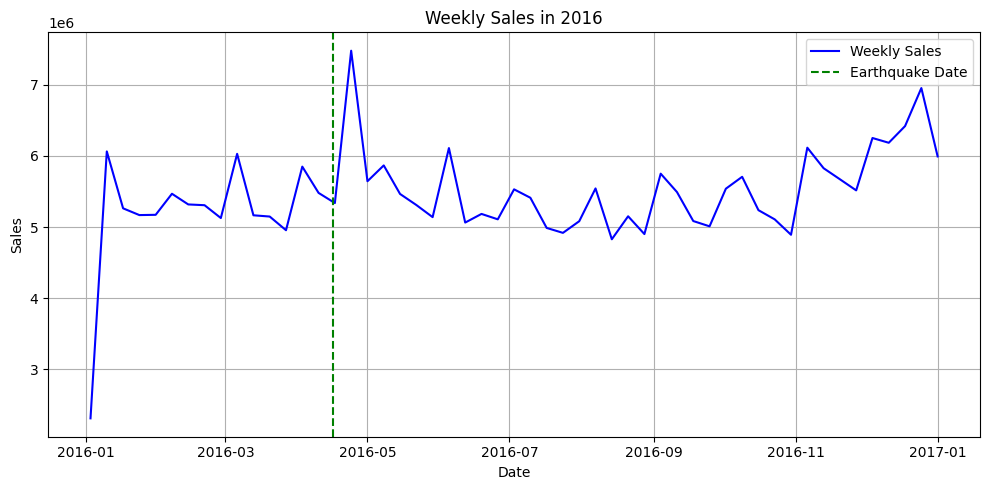

In [58]:

# Filter data for the year 2016
data_2016 =train_data[train_data['date'].dt.year == 2016].set_index('date')

# Resample data to weekly frequency
weekly_sales =data_2016.resample('W').sum()

# Date of the earthquake
earthquake_date = "2016-04-16"

# Visualization for weekly sales
plt.figure(figsize=(10,5))
sns.lineplot(data=weekly_sales, x=weekly_sales.index, y='sales', label='Weekly Sales', color='blue')
plt.axvline(pd.to_datetime(earthquake_date), color='green', linestyle='--', label='Earthquake Date')
plt.title("Weekly Sales in 2016")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Observation
There is in increase of sales after the earthquakes


### 5.Are certain stores or groups of stores selling more products? (Cluster, city, state, type)

In [59]:
# Merge train data with stores data
train_store_merged = train_data.merge(stores_data,how='left',on='store_nbr')

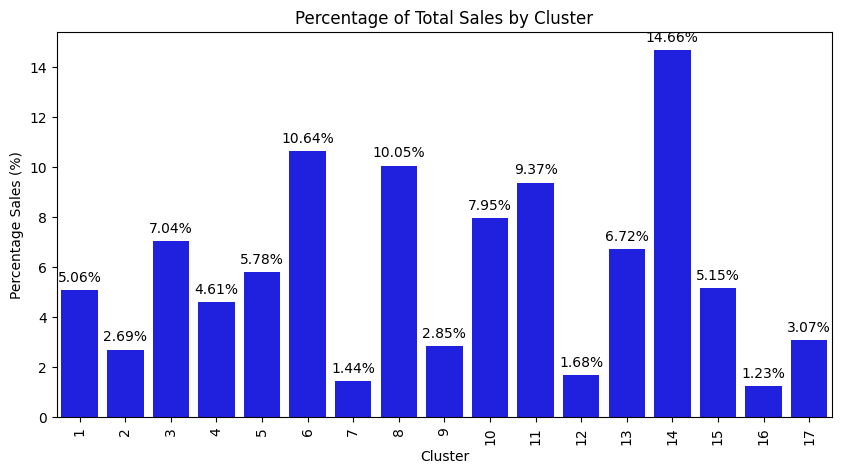

In [60]:

# Calculate total sales by cluster and sort in descending order
salesby_cluster = train_store_merged.groupby('cluster')['sales'].sum().sort_values(ascending=False)

# Calculate overall total sales
total_sales = train_store_merged['sales'].sum()

# Calculate percentage of sales by cluster
percentage_sales = (salesby_cluster / total_sales) * 100

# Create bar plot
plt.figure(figsize=(10, 5))
barplot = sns.barplot(x=percentage_sales.index, y=percentage_sales.values, color='blue')

# Add data labels
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f') + '%', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), 
                     textcoords = 'offset points')

# Set titles and labels
plt.title("Percentage of Total Sales by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Percentage Sales (%)")
plt.xticks(rotation=90)

# Show plot
plt.show()


### observations
- There are 17 clusters
- Cluster 14, 6 and 8 are the best selling cluster with each of them contributing above 10% of the total sales
- Cluster 14 is the best selling cluster with 14.66 percent of the total sales, cluster 6 is second best selling cluster with 10.64% of the total sales and cluster 8 is third best selling cluster with 10.05% of the total sales.
- The three worst selling clusters are 12 7 and 16. Each of them contributes less than 2% of the total sales


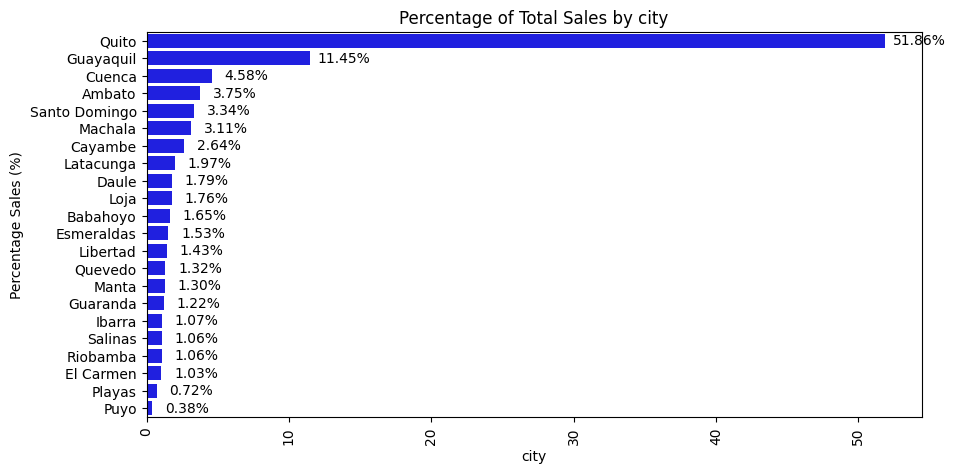

In [61]:
# calculate total sales by city
city_sales = train_store_merged.groupby('city')['sales'].sum().sort_values(ascending= False)

#calculate percentage of sales by city
percentage_sales =(city_sales/total_sales)*100

# plot a barplot
plt.figure(figsize =( 10,5))
barplot = sns.barplot(y = percentage_sales.index, x = percentage_sales.values, color = 'blue')

# Add data labels
for p in barplot.patches:
    barplot.annotate(format(p.get_width(), '.2f') + '%', 
                     (p.get_width(), p.get_y() + p.get_height() / 2.), 
                     ha = 'center', va = 'center', 
                     xytext = (25, 0), 
                     textcoords = 'offset points')
# Set titles and labels
plt.title("Percentage of Total Sales by city")
plt.xlabel("city")
plt.ylabel("Percentage Sales (%)")
plt.xticks(rotation=90)

# Show plot
plt.show()

### observation
- Quito is the best location with 51.86 percent sales of the total sales. it is the best location by far considering the second best location is at 11.45 percent
- The worst performing locations are Puyo City and Playas City with 0.38 and 0.72 percent sales

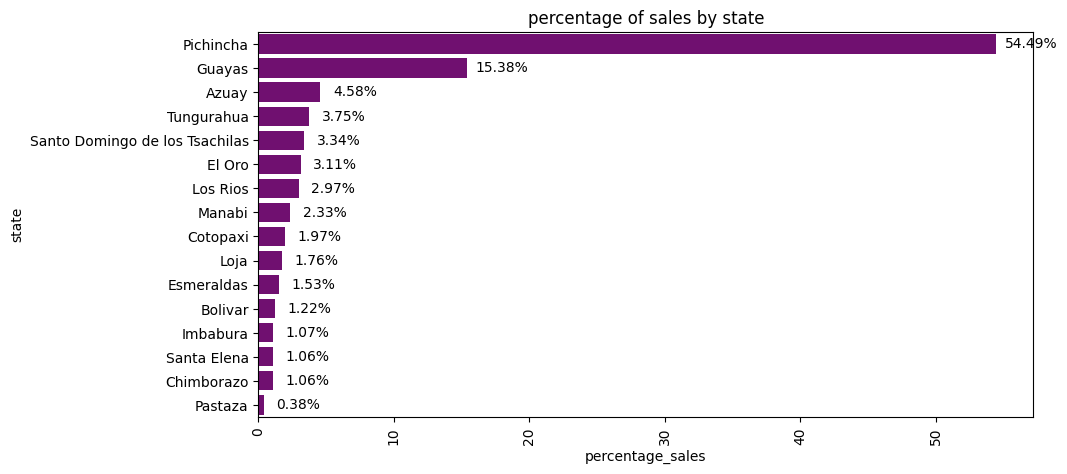

In [62]:
# calculate total sales by state
state_sales = train_store_merged.groupby('state')['sales'].sum().sort_values(ascending = False)

#calculate percentage of sales by state
percentage_sales =(state_sales/total_sales)*100 

# plot a barplot
plt.figure(figsize = (10,5))
barplot = sns.barplot(y = percentage_sales.index, x = percentage_sales.values,color = 'purple')

# adding data labels
for p in barplot.patches:
    barplot.annotate(format(p.get_width(), '.2f') + '%', 
                     (p.get_width(), p.get_y() + p.get_height() / 2.), 
                     ha = 'center', va = 'center', 
                     xytext = (25, 0), 
                     textcoords = 'offset points')
plt.title('percentage of sales by state')
plt.xlabel('percentage_sales')
plt.ylabel('state')
plt.xticks(rotation = 90)
plt.show()

### observations
- Pichicha is by far the best performing state contributing 54.49% of the total sales. The second is Guayas at 15.38 percent of the total sales

- The worst performing state is Pastaza at 0.38% of the total sales

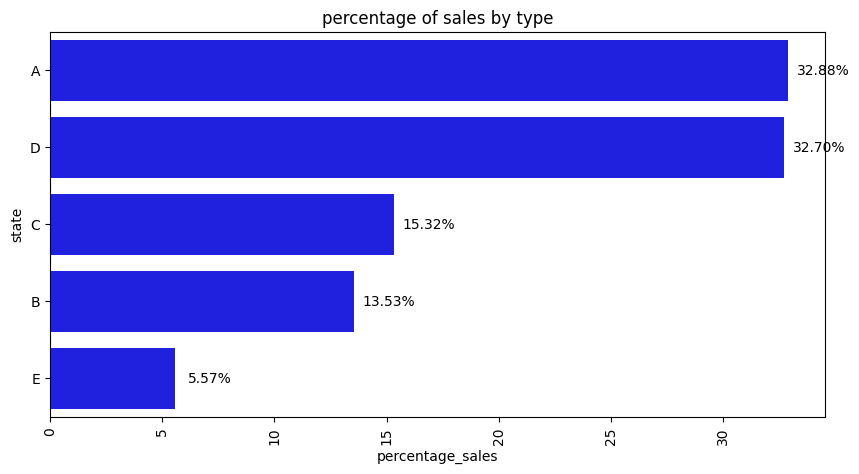

In [63]:
# calculate total sales by type
type_sales = train_store_merged.groupby('type')['sales'].sum().sort_values(ascending = False)

#calculate percentage of sales by state
percentage_sales =(type_sales/total_sales)*100 

# plot a barplot
plt.figure(figsize = (10,5))
barplot = sns.barplot(y = percentage_sales.index, x = percentage_sales.values,color = 'blue')

# adding data labels
for p in barplot.patches:
    barplot.annotate(format(p.get_width(), '.2f') + '%', 
                     (p.get_width(), p.get_y() + p.get_height() / 2.), 
                     ha = 'center', va = 'center', 
                     xytext = (25, 0), 
                     textcoords = 'offset points')
plt.title('percentage of sales by type')
plt.xlabel('percentage_sales')
plt.ylabel('state')
plt.xticks(rotation = 90)
plt.show()

### observation
- Store types are A and D are the best performers with 32.88 and 32.7 percent sales  respectively

- Store types E are the worst performers with 5.57%

### **6. Are sales affected by promotions, oil prices and holidays?**

In [64]:
#sales affected by holidays
# Get number of holidays
holidays_events_data['type'].value_counts()



type
Holiday       221
Event          56
Additional     51
Transfer       12
Bridge          5
Work Day        5
Name: count, dtype: int64

In [65]:
# get holidays_events_data info
holidays_events_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   transferred  350 non-null    bool  
dtypes: bool(1), object(4)
memory usage: 11.4+ KB


In [66]:
# Covert date to date time 

holidays_events_data['date'] = pd.to_datetime(holidays_events_data['date'])

In [67]:
# merge train and holidays dataset

merge_train_hols = train_data_cp.merge(holidays_events_data, how='left', on=['date'])
    
merge_train_hols.reset_index()
merge_train_hols.head()

,id,date,store_nbr,family,sales,onpromotion,onpromotion_encoded,year,type,locale,locale_name,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,0,2013,Holiday,National,Ecuador,False
1,1,2013-01-01,1,BABY CARE,0.0,0,0,2013,Holiday,National,Ecuador,False
2,2,2013-01-01,1,BEAUTY,0.0,0,0,2013,Holiday,National,Ecuador,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,0,2013,Holiday,National,Ecuador,False
4,4,2013-01-01,1,BOOKS,0.0,0,0,2013,Holiday,National,Ecuador,False


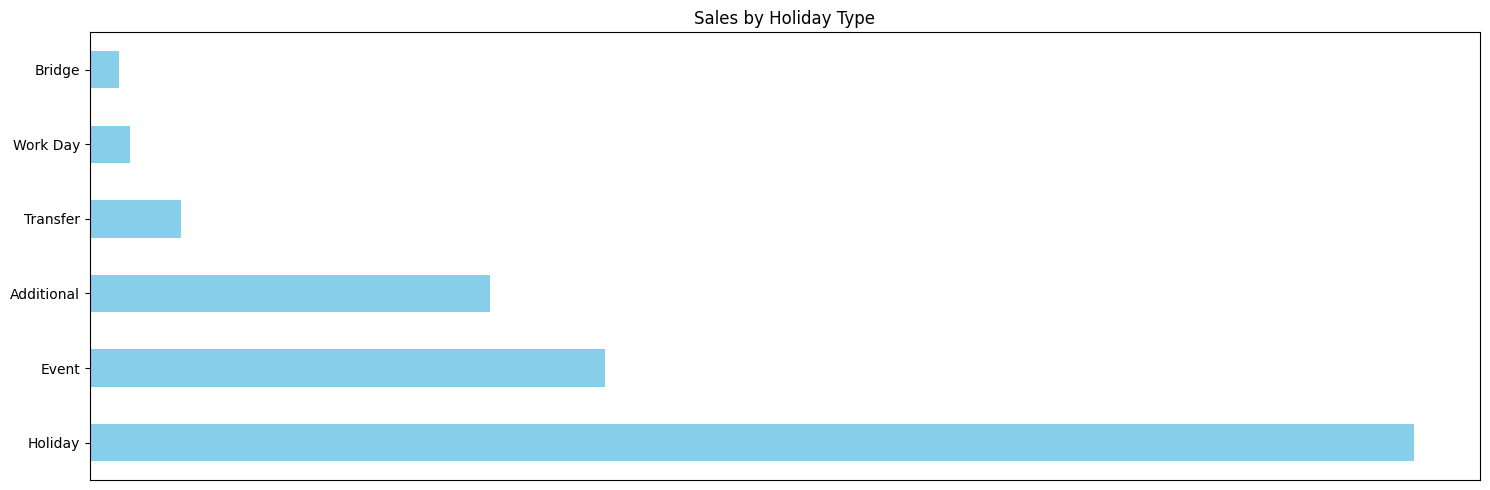

In [68]:
# Group the data by holiday type and calculate the sum of sales for each type
sales_by_holiday_type = merge_train_hols.groupby("type").agg({"sales": "sum"}).sort_values(by="sales", ascending=False)

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(15, 5))

# Plot a horizontal bar chart of the sales by holiday type
sales_by_holiday_type.plot(kind="barh", ax=ax, color='skyblue')

# Add a title and labels
ax.set_title("Sales by Holiday Type")
ax.set_ylabel("Holiday Type")
ax.legend().set_visible(False)
plt.xticks([])
plt.ylabel('')
plt.tight_layout()
plt.show()


### 7. What analysis can we get from the date and its extractable features?


In [69]:
train_data_cp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 8 columns):
 #   Column               Dtype         
---  ------               -----         
 0   id                   int64         
 1   date                 datetime64[ns]
 2   store_nbr            int64         
 3   family               object        
 4   sales                float64       
 5   onpromotion          int64         
 6   onpromotion_encoded  int32         
 7   year                 int32         
dtypes: datetime64[ns](1), float64(1), int32(2), int64(3), object(1)
memory usage: 160.3+ MB


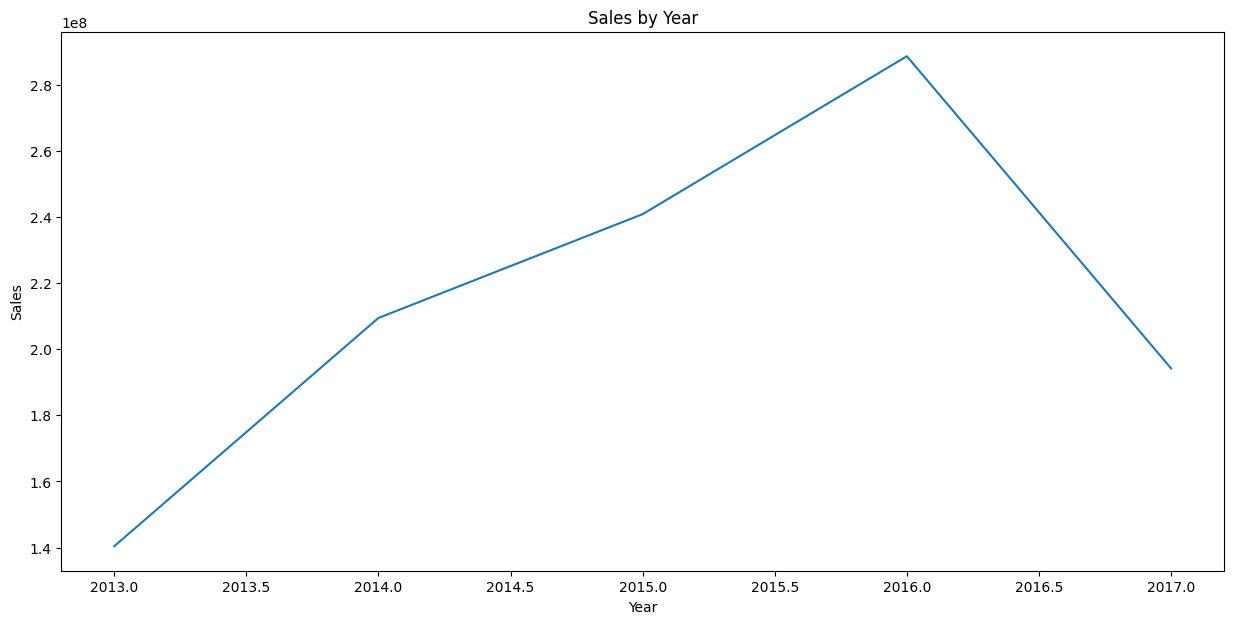

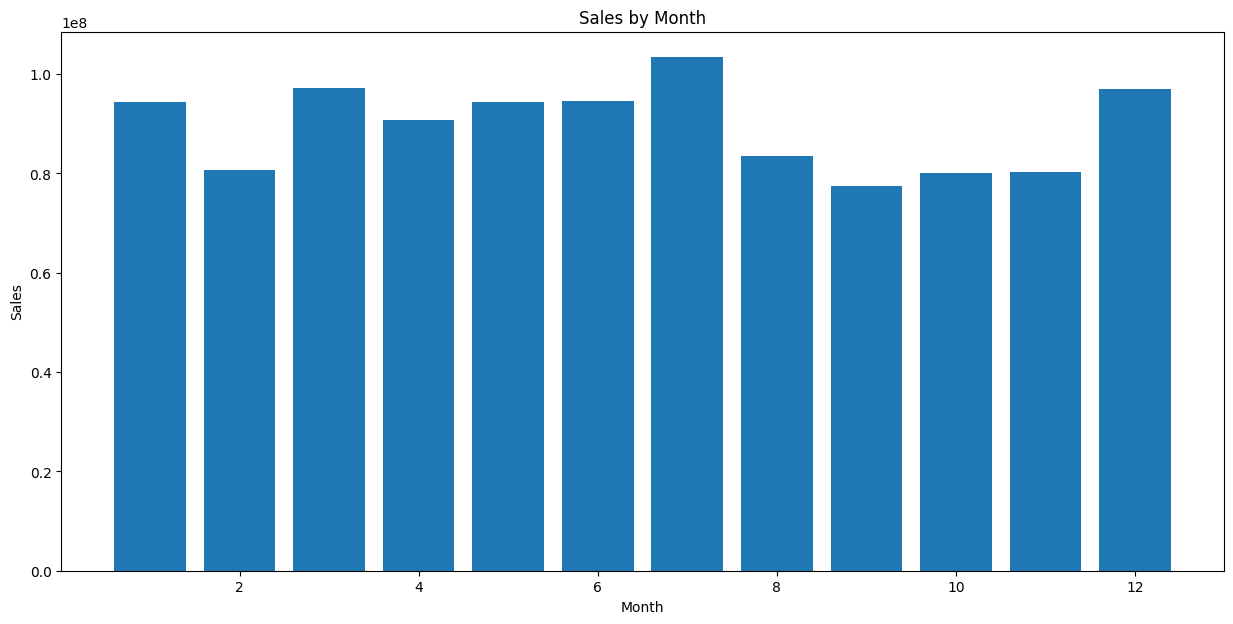

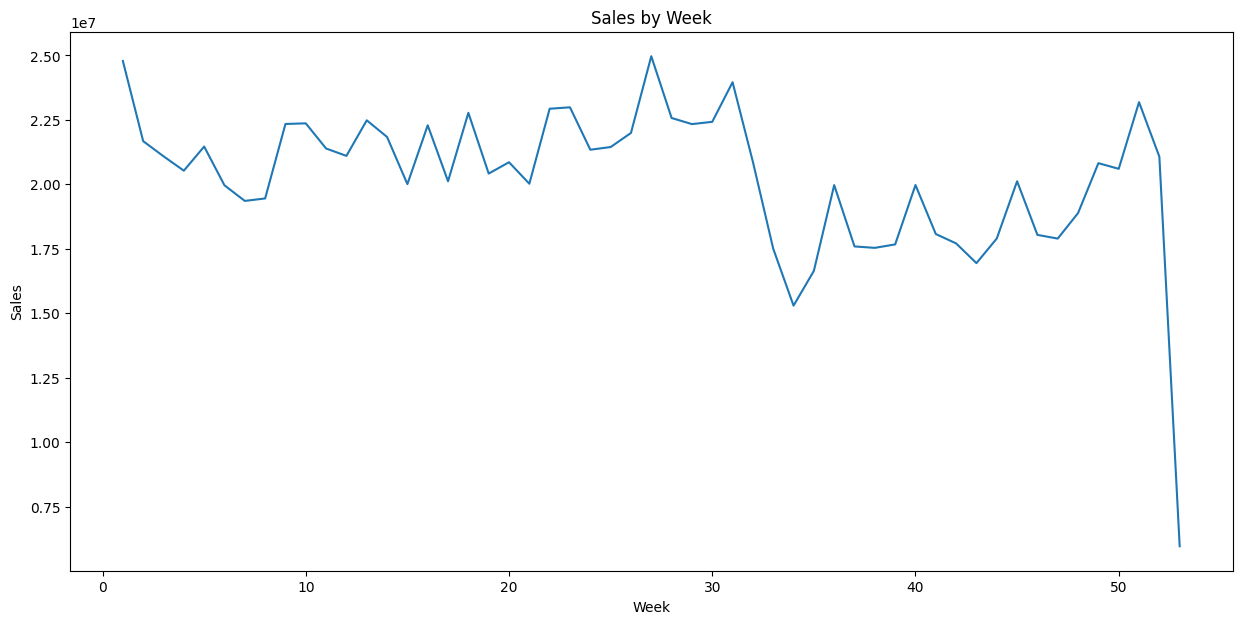

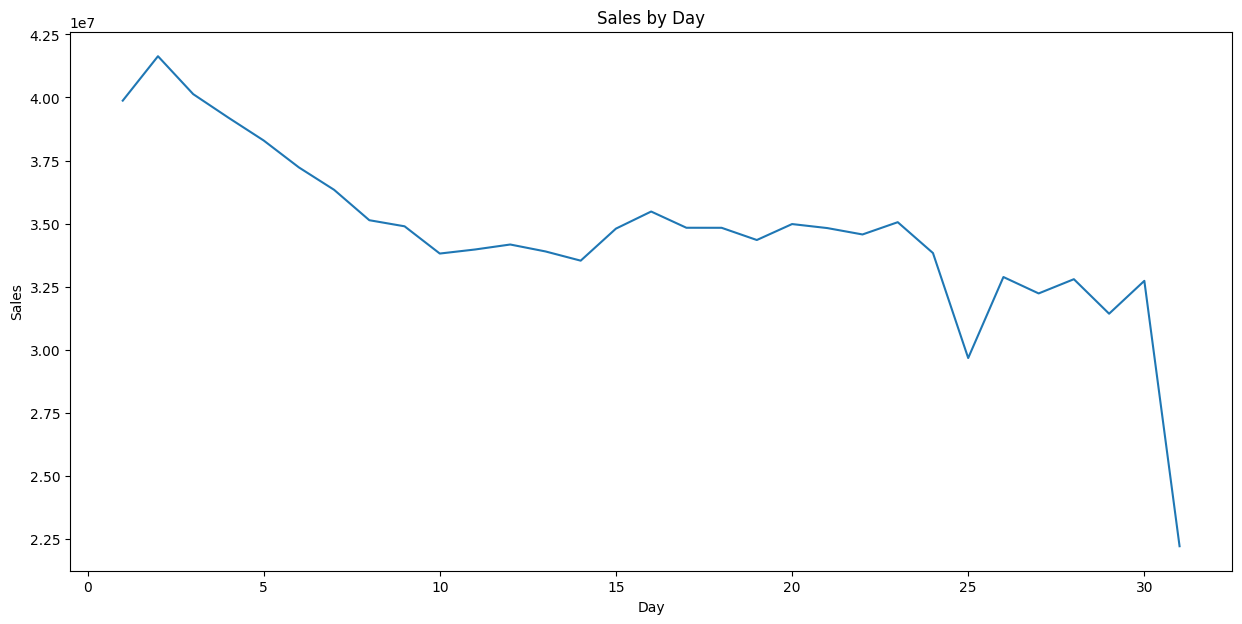

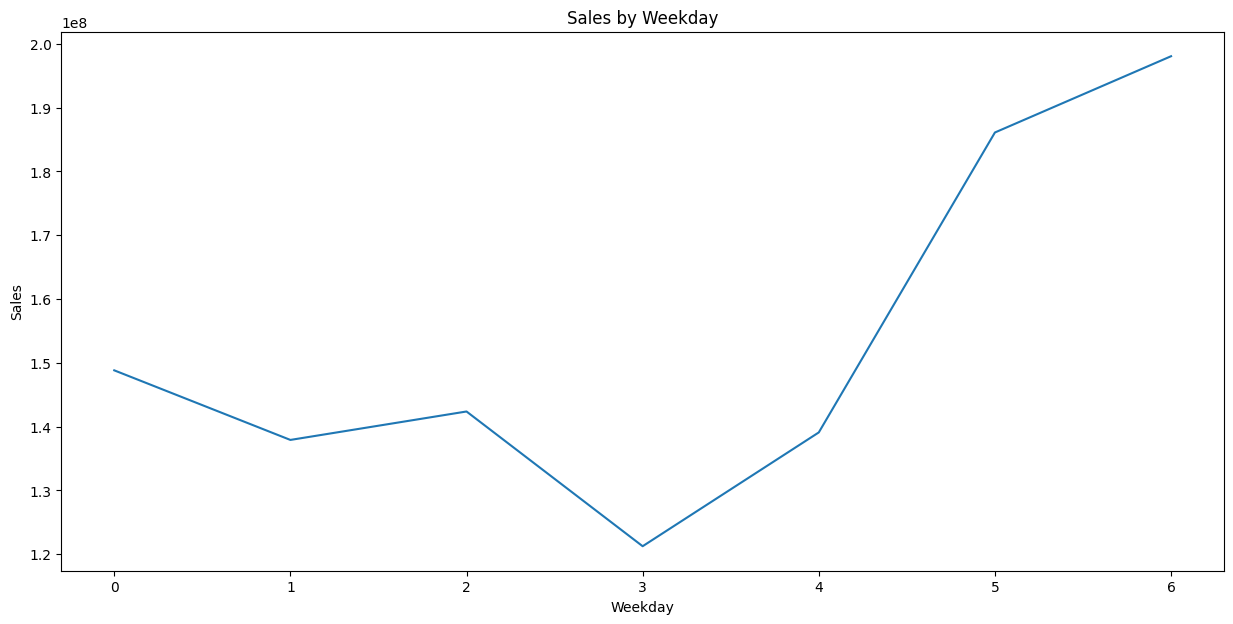

In [70]:
# extract year, quarter, month, day, and weekday information from the date column
train_data_cp['year'] = train_data_cp['date'].dt.year
train_data_cp['month'] = train_data_cp['date'].dt.month
train_data_cp['week'] = train_data_cp['date'].dt.isocalendar().week
train_data_cp['day'] = train_data_cp['date'].dt.day
train_data_cp['weekday'] = train_data_cp['date'].dt.weekday

# plot the aggregated sales data by year
grouped_by_year = train_data_cp.groupby('year')['sales'].sum()
plt.figure(figsize=(15, 7))
plt.plot(grouped_by_year.index, grouped_by_year.values)
plt.xlabel("Year")
plt.ylabel("Sales")
plt.title("Sales by Year")
plt.show()

# plot the aggregated sales data by month
grouped_by_month = train_data_cp.groupby('month')['sales'].sum()
plt.figure(figsize=(15, 7))
plt.bar(grouped_by_month.index, grouped_by_month.values)
plt.xlabel("Month")
plt.ylabel("Sales")
plt.title("Sales by Month")
plt.show()

# plot the aggregated sales data by week
grouped_by_week = train_data_cp.groupby('week')['sales'].sum()
plt.figure(figsize=(15, 7))
plt.plot(grouped_by_week.index, grouped_by_week.values)
plt.xlabel("Week")
plt.ylabel("Sales")
plt.title("Sales by Week")
plt.show()

# plot the aggregated sales data by day
grouped_by_day = train_data_cp.groupby('day')['sales'].sum()
plt.figure(figsize=(15, 7))
plt.plot(grouped_by_day.index, grouped_by_day.values)
plt.xlabel("Day")
plt.ylabel("Sales")
plt.title("Sales by Day")
plt.show()

# plot the aggregated sales data by weekday
grouped_by_weekday = train_data_cp.groupby('weekday')['sales'].sum()
plt.figure(figsize=(15, 7))
plt.plot(grouped_by_weekday.index, grouped_by_weekday.values)
plt.xlabel("Weekday")
plt.ylabel("Sales")
plt.title("Sales by Weekday")
plt.show()

### 8. Which product family and stores did the promotions affect?


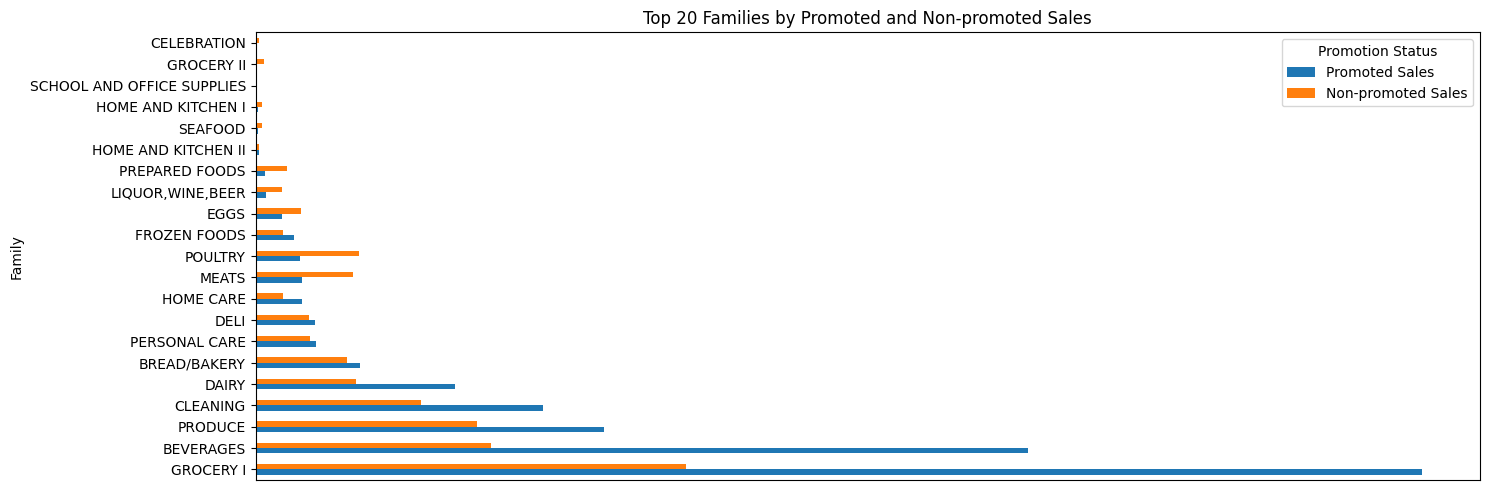

In [71]:
# Filter the DataFrame to include only rows where onpromotion_encoded is equal to 1
promoted_data = train_data_cp[train_data_cp['onpromotion_encoded'] == 1]
non_promoted_data = train_data_cp[train_data_cp['onpromotion_encoded'] == 0]

# Group by the family column and sum up the sales for each group, then sort the result
grouped_sales_promotion = promoted_data.groupby('family')['sales'].sum().sort_values(ascending=False).head(20)
non_promoted_data_grp = non_promoted_data.groupby('family')['sales'].sum().sort_values(ascending=False).head(20)

# Rename columns for clarity
grouped_sales_promotion = grouped_sales_promotion.rename('Promoted Sales')
non_promoted_data_grp = non_promoted_data_grp.rename('Non-promoted Sales')

# Convert the result to a DataFrame
grouped_sales_promotion = pd.concat([grouped_sales_promotion, non_promoted_data_grp], axis=1)

# Plotting
grouped_sales_promotion.plot(kind='barh', figsize=(15, 5))
plt.title('Top 20 Families by Promoted and Non-promoted Sales')
plt.ylabel('Family')
plt.xticks([])
plt.legend(title='Promotion Status')
plt.tight_layout()
plt.show()

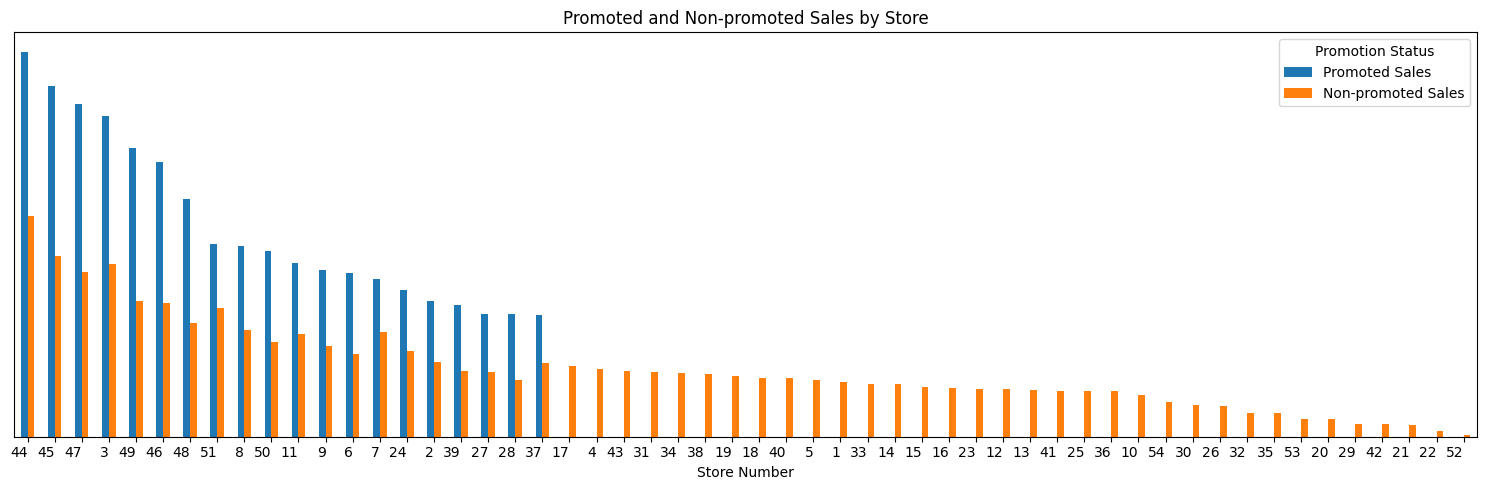

In [72]:
# Group by the family column and sum up the sales for each group, then sort the result
grouped_sales_promotion_str = promoted_data.groupby('store_nbr')['sales'].sum().sort_values(ascending=False).head(20)
non_promoted_data_grp_str = non_promoted_data.groupby('store_nbr')['sales'].sum().sort_values(ascending=False)

# Rename columns for clarity
grouped_sales_promotion_str = grouped_sales_promotion_str.rename('Promoted Sales')
non_promoted_data_grp_str = non_promoted_data_grp_str.rename('Non-promoted Sales')

# Convert the result to a DataFrame
grouped_sales_promotion_str = pd.concat([grouped_sales_promotion_str, non_promoted_data_grp_str], axis=1)

# Plotting
grouped_sales_promotion_str.plot(kind='bar', figsize=(15, 5))
plt.title('Promoted and Non-promoted Sales by Store')
plt.xlabel('Store Number')
plt.yticks([])
plt.xticks(rotation=0, ha='right')
plt.legend(title='Promotion Status')
plt.tight_layout()
plt.show()

### 9. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

1. **Mean Absolute Error (MAE)**: This metric calculates the average of absolute differences between the forecasted values and the actual values. It provides a linear penalty for each unit of difference. 

    \[ \text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i| \]

2. **Mean Squared Error (MSE)**: This metric calculates the average of the squares of the differences between the forecasted values and the actual values. It provides a quadratic penalty for each unit of difference, which means larger errors are more heavily penalized.

    \[ \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 \]

3. **Root Mean Squared Error (RMSE)**: This is simply the square root of MSE. It's a popular metric because it represents the sample standard deviation of the differences between predicted values and observed values.

    \[ \text{RMSE} = \sqrt{\text{MSE}} \]

4. **Root Mean Squared Logarithmic Error (RMSLE)**: It calculates the difference between the log-transformed predicted and actual values. It's particularly useful when you care more about percentage errors rather than the absolute value of errors.

    \[ \text{RMSLE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (\log(y_i + 1) - \log(\hat{y}_i + 1))^2} \]

**Why might MAE be greater than RMSE?**

It's not necessarily true that MAE is always greater than RMSE, but it can be, depending on the dataset. Since RMSE squares the errors before averaging and then takes the square root, it tends to give more weight to larger errors. This means RMSE should be more useful when large errors are particularly undesirable. Here are some differences:

- **Outliers**: RMSE is highly sensitive to outliers, whereas MAE is robust to outliers. If you have many outliers, the squared differences can lead to a much higher RMSE compared to MAE.
  
- **Error Distribution**: If all errors are consistently of the same magnitude, then MAE and RMSE will be similar. However, if some errors are much larger than others (a mix of small and large errors), RMSE will tend to be larger than MAE.

- **Interpretability**: MAE directly represents the average error magnitude, which can sometimes be more interpretable than RMSE.

In general, if you're comparing two models, it's a good practice to consider both MAE and RMSE as they can provide different insights into the errors the models are making.

### 10. Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.

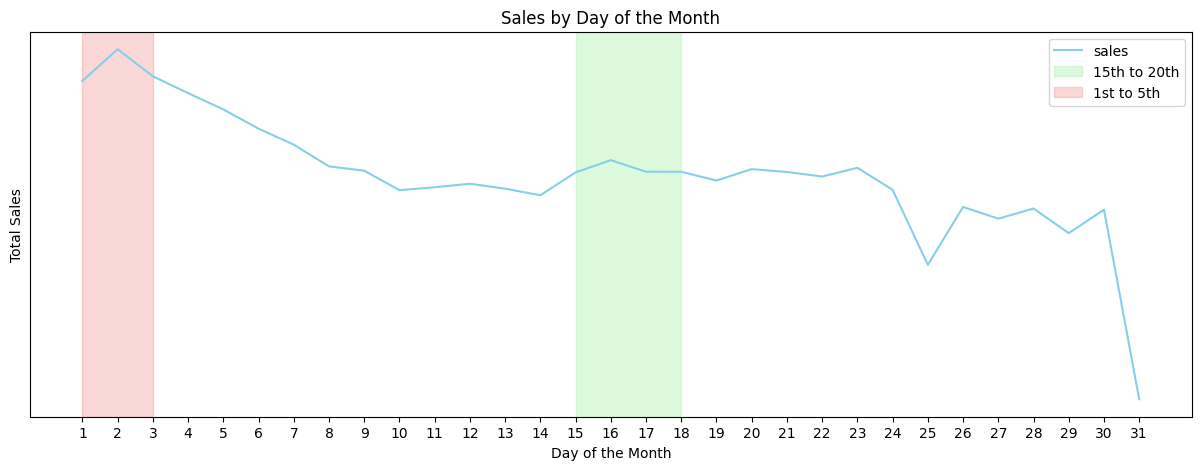

In [73]:
# Sales by day of the month
train_data_cp['day_of_month'] = train_data_cp['date'].dt.day
sales_by_day_of_month = train_data_cp.groupby('day_of_month')['sales'].sum()
sales_by_day_of_month.plot(kind='line', figsize=(15, 5),
                            xlabel='Day of the Month', 
                            ylabel='Total Sales', 
                            title='Sales by Day of the Month',
                            color='skyblue')

# Highlighting different periods with different colors
plt.axvspan(15, 18, color='lightgreen', alpha=0.3, label='15th to 20th')
plt.axvspan(1, 1 + 2, color='lightcoral', alpha=0.3, label='1st to 5th')

plt.xticks(range(1, 32), rotation='horizontal')
plt.yticks([])
plt.legend()
plt.show()


## Data preparation

In [74]:
# Convert missing dates data to a dataframe
train_missing_dates = pd.DataFrame(train_missing_dates).rename(columns={0: 'date'})
train_missing_dates

,date
0,2013-12-25
1,2014-12-25
2,2015-12-25
3,2016-12-25


In [75]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 8 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
 6   year         int32         
 7   month        int32         
dtypes: datetime64[ns](1), float64(1), int32(2), int64(3), object(1)
memory usage: 160.3+ MB


In [76]:

# Now convert to datetime format
train_data['date'] = pd.to_datetime(train_data['date'])

In [77]:
# Handle the missing dates
train_data = pd.merge(train_data, train_missing_dates, how='outer', on='date')

In [78]:
train_data= train_data.drop(columns=['year','month'])

In [79]:
train_data.tail(10)

,id,date,store_nbr,family,sales,onpromotion
3000882,3000878.0,2017-08-15,9.0,MAGAZINES,11.000,0.0
3000883,3000879.0,2017-08-15,9.0,MEATS,449.228,0.0
3000884,3000880.0,2017-08-15,9.0,PERSONAL CARE,522.000,11.0
3000885,3000881.0,2017-08-15,9.0,PET SUPPLIES,6.000,0.0
3000886,3000882.0,2017-08-15,9.0,PLAYERS AND ELECTRONICS,6.000,0.0
3000887,3000883.0,2017-08-15,9.0,POULTRY,438.133,0.0
3000888,3000884.0,2017-08-15,9.0,PREPARED FOODS,154.553,1.0
3000889,3000885.0,2017-08-15,9.0,PRODUCE,2419.729,148.0
3000890,3000886.0,2017-08-15,9.0,SCHOOL AND OFFICE SUPPLIES,121.000,8.0
3000891,3000887.0,2017-08-15,9.0,SEAFOOD,16.000,0.0


In [80]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000892 entries, 0 to 3000891
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           float64       
 1   date         datetime64[ns]
 2   store_nbr    float64       
 3   family       object        
 4   sales        float64       
 5   onpromotion  float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 137.4+ MB


In [81]:
#check for null values
train_data.isnull().sum()

id             4
date           0
store_nbr      4
family         4
sales          4
onpromotion    4
dtype: int64

In [82]:
# Fill the missing values with interpolation
train_data = train_data.interpolate(method='linear', axis=0).ffill().bfill()

## stationarity

In [83]:
# Set up the training data
train_cols = ['date', 'sales']

train_daily_total_sales = train_data[train_cols].set_index('date').resample('D').sum()
print(train_daily_total_sales.shape)
train_daily_total_sales.head()

(1688, 1)


,sales
date,
2013-01-01,2511.618999
2013-01-02,496092.417944
2013-01-03,361461.231124
2013-01-04,354459.677093
2013-01-05,477350.121229


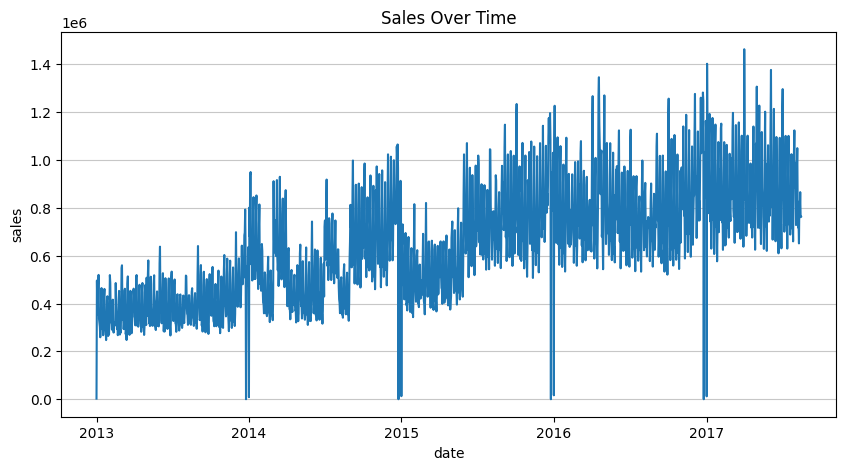

In [84]:
plt.figure(figsize=(10,5))
sns.lineplot(
    x=train_daily_total_sales.index,
    y=train_daily_total_sales['sales']
    )
plt.title('Sales Over Time')
plt.grid(axis='y', alpha=0.7)
plt.show()

- From the lineplot above, we can see that the time series has a clear upward trend and variations from the mean. This suggests non-stationarity. Hence, our Null hypothesis will be that the time series is non-stationary as we can infer from the the plot while the Null hypothesis will be that the time series is stationary

H0: **The time series is non-stationary.**

HA: **The time series is stationary.**

In [85]:
# ADF Test
# Function to perform ADF test and return results
def adf_test(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    return dfoutput

# Call the function and run the test
adf_results = adf_test(train_daily_total_sales['sales'])
if adf_results['p-value'] < 0.05:
    print('The time series is stationary.')
else:
    print('The time series is non-stationary.')


Results of Dickey-Fuller Test:
Test Statistic                   -2.571414
p-value                           0.099050
#Lags Used                       22.000000
Number of Observations Used    1665.000000
Critical Value (1%)              -3.434284
Critical Value (5%)              -2.863277
Critical Value (10%)             -2.567695
dtype: float64
The time series is non-stationary.


## observation
- The p-value obtained (0.10) is greater than the significance level of 0.05, and the Test Statistic (-2.57) is not more negative than any of the critical values.

- Therefore, based on these results, the null hypothesis cannot be rejected, indicating that there is insufficient evidence to conclude that the time series is stationary.

- This means we fail to reject the null hypothesis that the time series is non-stationary.

## Differencing

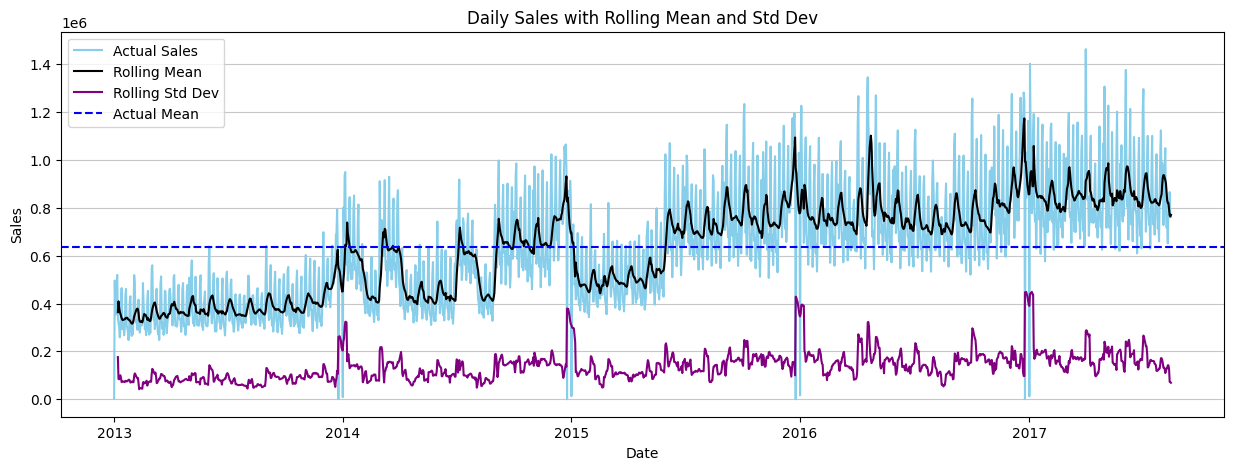

In [86]:
# Calculate mean and standard deviation of sales
sales_mean = train_daily_total_sales['sales'].mean()
sales_std = train_daily_total_sales['sales'].std()

# Plotting
plt.figure(figsize=(15, 5))

# Plot actual sales
plt.plot(train_daily_total_sales.index, train_daily_total_sales['sales'], label='Actual Sales', color='skyblue')

# Plot rolling mean
plt.plot(train_daily_total_sales.index, train_daily_total_sales['sales'].rolling(window=7).mean(), label='Rolling Mean', color='black',)

# Plot rolling standard deviation
plt.plot(train_daily_total_sales.index, train_daily_total_sales['sales'].rolling(window=7).std(), label='Rolling Std Dev', color='purple')

# Plot actual mean
plt.axhline(y=sales_mean, color='blue', linestyle='--', label='Actual Mean')

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Daily Sales with Rolling Mean and Std Dev')
plt.legend()
plt.grid(axis='y', alpha=0.7)
plt.show()

### **Notes**
- Rolling mean and standard deviation help in distinguishing signal (underlying trend or pattern) from noise (random fluctuations) in the data. By smoothing out noise, they make underlying patterns more apparent, aiding in decision-making and forecasting. Rolling mean smooths out short-term fluctuations and highlights longer-term trends in the data. This can help in identifying underlying patterns or trends that might not be apparent in the raw data.

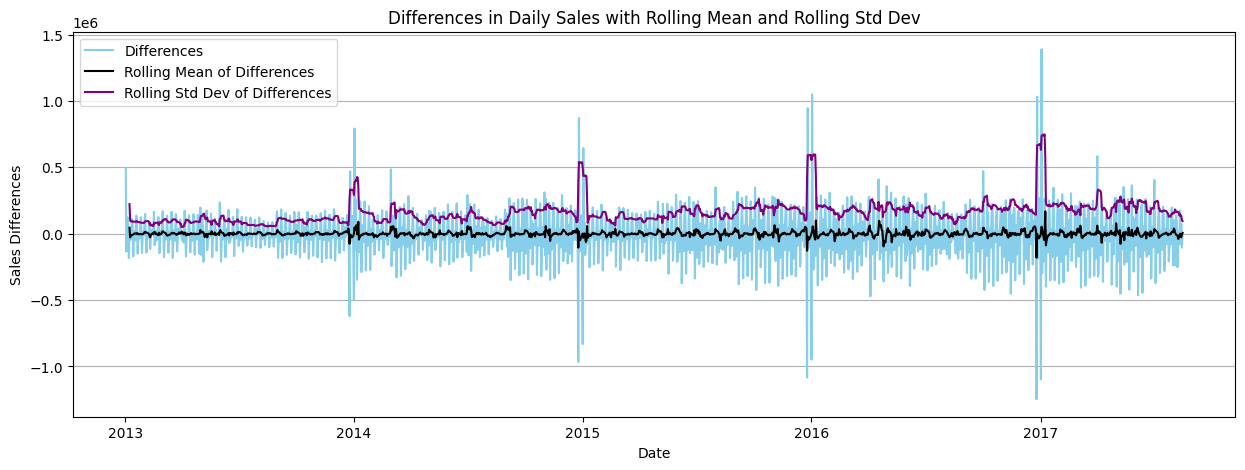

In [87]:
# Calculate differences
sales_diff = train_daily_total_sales['sales'].diff()

# Calculate rolling mean and standard deviation of differences
sales_diff_rolling_mean = sales_diff.rolling(window=7).mean()
sales_diff_std = sales_diff.rolling(window=7).std()

# Plotting
plt.figure(figsize=(15, 5))

# Plot differences
plt.plot(train_daily_total_sales.index, sales_diff, label='Differences', color='skyblue')

# Plot rolling mean of differences
plt.plot(train_daily_total_sales.index, sales_diff_rolling_mean, label='Rolling Mean of Differences', color='black')

# Plot rolling standard deviation of differences
plt.plot(train_daily_total_sales.index, sales_diff_std, label='Rolling Std Dev of Differences', color='purple')

plt.xlabel('Date')
plt.ylabel('Sales Differences')
plt.title('Differences in Daily Sales with Rolling Mean and Rolling Std Dev')
plt.legend()
plt.grid(axis='y')
plt.show()

In [88]:
#  Drop missing and infinite values
sales_diff_clean = sales_diff.dropna().replace([np.inf, -np.inf], np.nan).dropna()

# Call the function and run the test
adf_results_diff = adf_test(sales_diff_clean)

# Check if the p-value is less than 0.05
if adf_results_diff['p-value'] < 0.05:
    print('The time series is stationary.')
else:
    print('The time series is non-stationary.')

Results of Dickey-Fuller Test:
Test Statistic                -1.131158e+01
p-value                        1.235230e-20
#Lags Used                     2.500000e+01
Number of Observations Used    1.661000e+03
Critical Value (1%)           -3.434293e+00
Critical Value (5%)           -2.863282e+00
Critical Value (10%)          -2.567697e+00
dtype: float64
The time series is stationary.


We conclude our time series is stationary

In [89]:
# Combining the original time series and the differenced time series
train_daily_total_sales['diff_sales'] = sales_diff_clean
train_daily_total_sales['diff_sales_7'] = train_daily_total_sales['sales'].dropna().replace([np.inf, -np.inf], np.nan).dropna().diff(7)

train_daily_total_sales.head()

,sales,diff_sales,diff_sales_7
date,,,
2013-01-01,2511.618999,NaN,NaN
2013-01-02,496092.417944,493580.798945,NaN
2013-01-03,361461.231124,-134631.186820,NaN
2013-01-04,354459.677093,-7001.554031,NaN
2013-01-05,477350.121229,122890.444136,NaN


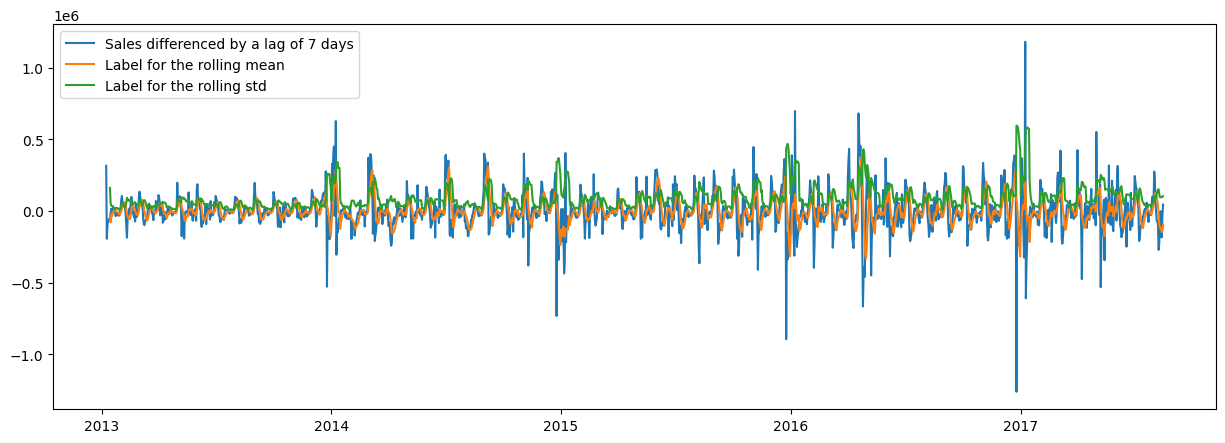

In [90]:
# Plot a figure showing sales differenced by a lag of 7
plt.figure(figsize=(15,5))
plt.plot(train_daily_total_sales['diff_sales_7'].dropna(), label='Sales differenced by a lag of 7 days')
plt.plot(train_daily_total_sales['diff_sales_7'].dropna().rolling(window=7).mean(), label='Label for the rolling mean')
plt.plot(train_daily_total_sales['diff_sales_7'].dropna().rolling(window=7).std(), label='Label for the rolling std')
plt.legend(loc='upper left',)

plt.show()

## Modelling

### Splitting the data

In [91]:
# Split the data into train and test
train = train_daily_total_sales.loc[train_daily_total_sales.index < "2017-06-01"]
test = train_daily_total_sales.loc[train_daily_total_sales.index >= "2017-06-01"]

In [92]:
# Shape of the data
train.shape,test.shape

((1612, 3), (76, 3))

### modelling

1.SARIMA model

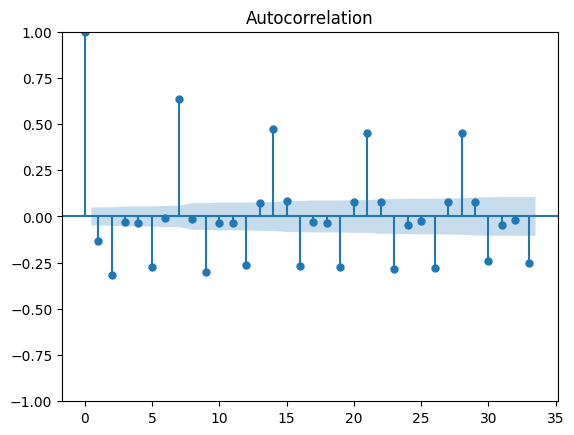

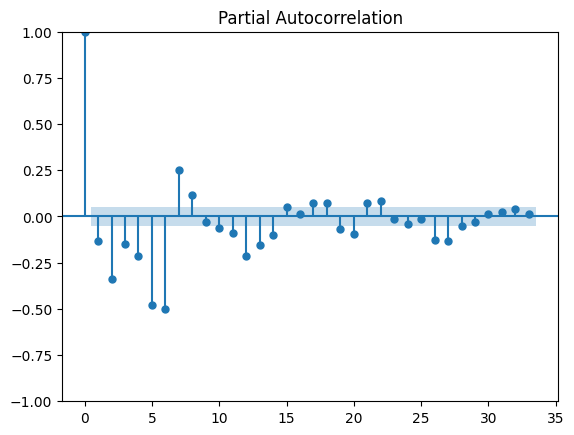

In [93]:
# Plotting acf and pcf
acf = plot_acf(train['diff_sales'].dropna())
pacf = plot_pacf(train['diff_sales'].dropna())

In [94]:
# Model instatiation
sarima_model = auto_arima(
    train['diff_sales'].dropna(),
    seasonal=True,
    m=7,
    stepwise=True,
    )

# Model summary
print(sarima_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1611
Model:             SARIMAX(4, 0, 2)x(1, 0, 2, 7)   Log Likelihood              -20967.987
Date:                           Sun, 04 Aug 2024   AIC                          41957.973
Time:                                   17:30:56   BIC                          42017.204
Sample:                               01-02-2013   HQIC                         41979.960
                                    - 05-31-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1449.6890    724.016      2.002      0.045      30.644    2868.734
ar.L1         -1.5735      0.103    -15.204

In [95]:
# Get model order
print(f'Sarima model order: {sarima_model.order}')

# Get model seasonal order
print(f'Sarima model seasonal order: {sarima_model.seasonal_order}')

Sarima model order: (4, 0, 2)
Sarima model seasonal order: (1, 0, 2, 7)


In [96]:
# Fit data into the model
sarima_model_fit = sarima_model.fit(train['diff_sales'].dropna())
sarima_model_fit

ARIMA(order=(4, 0, 2), scoring_args={}, seasonal_order=(1, 0, 2, 7),
      suppress_warnings=True)

In [97]:
# Predict
period_predict = len(test['diff_sales'].dropna())

sarima_model_predict = sarima_model_fit.predict(n_periods=period_predict, order=sarima_model.order)

In [98]:
# Model Evaluation
mae = mean_absolute_error(test['diff_sales'].dropna(), sarima_model_predict)
rmse = np.sqrt(mean_squared_error(test['diff_sales'].dropna(), sarima_model_predict))

# RMSLE
def rmsle(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

rmsle_value = rmsle(test['diff_sales'].dropna(), sarima_model_predict) 


print('SARIMA Model metrics:')
print(f'RMSLE: {rmsle_value}')

print(f'MAE: {mae}')

print(f'RMSE: {rmse}')

SARIMA Model metrics:
RMSLE: 0.7836145399432425
MAE: 60053.3670013234
RMSE: 82579.61943975974


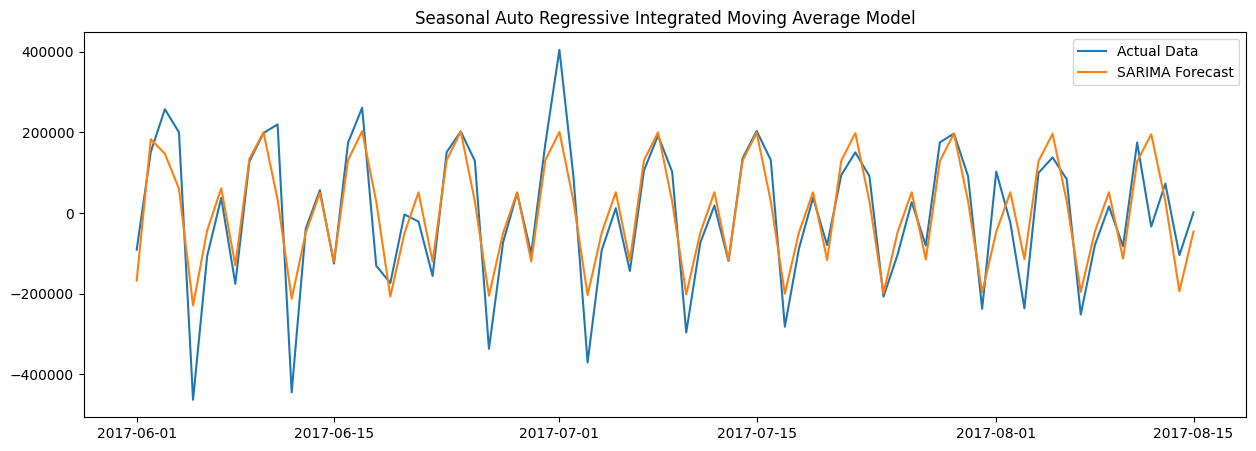

In [99]:
# plot the train, evaluation and model predictions
plt.figure(figsize = (15,5))
plt.plot(test['diff_sales'], label = 'Actual Data')
plt.plot (sarima_model_predict, label = 'SARIMA Forecast')
plt.legend(loc='upper right')
plt.title('Seasonal Auto Regressive Integrated Moving Average Model')
plt.show()

### ARIMA 

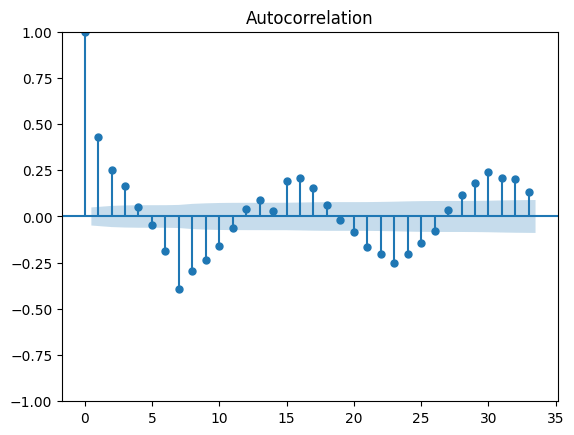

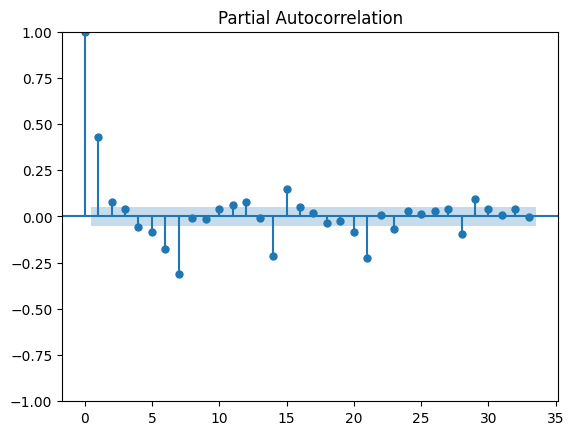

In [100]:
# Plotting acf and pcf
acf = plot_acf(train['diff_sales_7'].dropna())
pacf = plot_pacf(train['diff_sales_7'].dropna())

In [101]:
# Model instatiation
arima_model = auto_arima(
    train['diff_sales_7'].dropna(),
    seasonal=False,
    m=7,
    stepwise=True,
    d=0 
)

In [102]:
# Get model and seasonal orders

print(f'ARIMA model order: {arima_model.order}')

print(f'ARIMA model seasonal order: {arima_model.seasonal_order}')

ARIMA model order: (2, 0, 3)
ARIMA model seasonal order: (0, 0, 0, 0)


In [103]:
# Fit data into ARIMA model

arima_model_fit = arima_model.fit(train['diff_sales_7'].dropna(), order=arima_model.order)

# Do the predictions

period_predict = len(test['diff_sales_7'].dropna())

arima_model_predict = arima_model_fit.predict(n_periods=period_predict)

# Model Evaluation

mae = mean_absolute_error(test['diff_sales_7'].dropna(), arima_model_predict)

rmse = np.sqrt(mean_squared_error(test['diff_sales_7'].dropna(), arima_model_predict))

# RMSLE
def rmsle(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

rmsle_value = rmsle(test['diff_sales'].dropna(), arima_model_predict) 

print('ARIMA Model Metrics:')

print(f'MAE: {mae}')

print(f'RMSE: {rmse}')

print(f'RMSLE: {rmsle_value}')

ARIMA Model Metrics:
MAE: 79652.34348836508
RMSE: 104271.24628892526
RMSLE: 2.1155238894170676


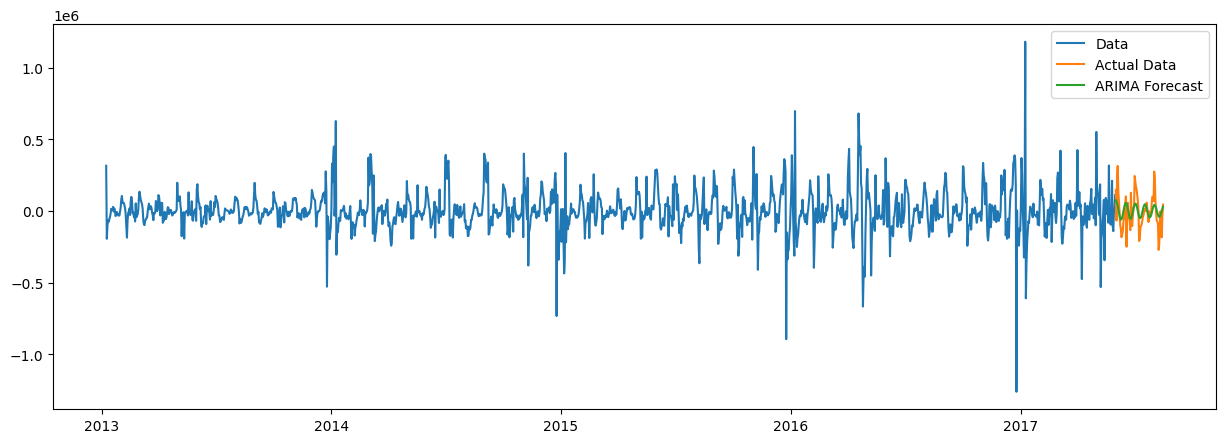

In [104]:
# PLot the model

plt.figure(figsize = (15,5))

plt.plot(train['diff_sales_7'], label = 'Data')
plt.plot(test['diff_sales_7'], label = 'Actual Data')

plt.plot (arima_model_predict, label = 'ARIMA Forecast')

plt.legend(loc='upper right')

### Machine Learning

#### Data preparation

In [105]:
train_data.head()

,id,date,store_nbr,family,sales,onpromotion
0,0.0,2013-01-01,1.0,AUTOMOTIVE,0.0,0.0
1,1.0,2013-01-01,1.0,BABY CARE,0.0,0.0
2,2.0,2013-01-01,1.0,BEAUTY,0.0,0.0
3,3.0,2013-01-01,1.0,BEVERAGES,0.0,0.0
4,4.0,2013-01-01,1.0,BOOKS,0.0,0.0


In [106]:
train_data.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [107]:
# drop ID column
train_data = train_data.drop(['id'], axis=1)

In [108]:
# Aggregare train data
train_aggregated = train_data.groupby(['family', 'date', 'store_nbr']).agg({'sales' : 'sum', 'onpromotion' : 'sum'}).reset_index()
train_aggregated.tail()

,family,date,store_nbr,sales,onpromotion
3000887,SEAFOOD,2017-08-15,50.0,15.314,0.0
3000888,SEAFOOD,2017-08-15,51.0,52.876,0.0
3000889,SEAFOOD,2017-08-15,52.0,7.000,0.0
3000890,SEAFOOD,2017-08-15,53.0,5.000,0.0
3000891,SEAFOOD,2017-08-15,54.0,3.000,0.0


### Feature Engineering

In [109]:
# Get month
train_aggregated['month'] = train_aggregated['date'].dt.month

# Get day
train_aggregated['dayofweek'] = train_aggregated['date'].dt.day_of_week

# Get weekend

train_aggregated['weekend'] = np.where(train_aggregated['dayofweek'].isin(['Saturday', 'Sunday']), 'Yes', 'No')

# Get quarter
train_aggregated['quarter'] = train_aggregated['date'].dt.quarter

# Get week
train_aggregated['Week'] = train_aggregated['date'].dt.isocalendar().week

 # Get Pay data: 15th of the month and last day of the month
train_aggregated['is_payday'] = np.where((train_aggregated['date'].dt.day == 15) | (train_aggregated['date'].dt.is_month_end), 'Yes', 'No')


train_aggregated.head()


,family,date,store_nbr,sales,onpromotion,month,dayofweek,weekend,quarter,Week,is_payday
0,AUTOMOTIVE,2013-01-01,1.0,0.0,0.0,1,1,No,1,1,No
1,AUTOMOTIVE,2013-01-01,2.0,0.0,0.0,1,1,No,1,1,No
2,AUTOMOTIVE,2013-01-01,3.0,0.0,0.0,1,1,No,1,1,No
3,AUTOMOTIVE,2013-01-01,4.0,0.0,0.0,1,1,No,1,1,No
4,AUTOMOTIVE,2013-01-01,5.0,0.0,0.0,1,1,No,1,1,No


In [110]:
# Set date as index
train_aggregated = train_aggregated.set_index('date')

train_aggregated.head()

,family,store_nbr,sales,onpromotion,month,dayofweek,weekend,quarter,Week,is_payday
date,,,,,,,,,,
2013-01-01,AUTOMOTIVE,1.0,0.0,0.0,1,1,No,1,1,No
2013-01-01,AUTOMOTIVE,2.0,0.0,0.0,1,1,No,1,1,No
2013-01-01,AUTOMOTIVE,3.0,0.0,0.0,1,1,No,1,1,No
2013-01-01,AUTOMOTIVE,4.0,0.0,0.0,1,1,No,1,1,No
2013-01-01,AUTOMOTIVE,5.0,0.0,0.0,1,1,No,1,1,No


In [111]:
# Check for nulls
train_aggregated.isna().sum()

family         0
store_nbr      0
sales          0
onpromotion    0
month          0
dayofweek      0
weekend        0
quarter        0
Week           0
is_payday      0
dtype: int64

In [112]:
train_aggregated.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3000892 entries, 2013-01-01 to 2017-08-15
Data columns (total 10 columns):
 #   Column       Dtype  
---  ------       -----  
 0   family       object 
 1   store_nbr    float64
 2   sales        float64
 3   onpromotion  float64
 4   month        int32  
 5   dayofweek    int32  
 6   weekend      object 
 7   quarter      int32  
 8   Week         UInt32 
 9   is_payday    object 
dtypes: UInt32(1), float64(3), int32(3), object(3)
memory usage: 208.9+ MB


## Modelling

#### Train Test Split

In [113]:
# Perform the train test split based on the time series order
start = '2017-01-01'
y = train_aggregated['sales']
X = train_aggregated.drop('sales',axis=1)


X_train_ml = X.loc[X.index < start]
X_test_ml = X.loc[X.index >= start]
y_train_ml = y.loc[y.index < start]
y_test_ml = y.loc[y.index >= start]

In [114]:
# Get split data shapes

print(f'X_train_ml shape: {X_train_ml.shape}')
print(f'X_test_ml shape: {X_test_ml.shape}')
print(f'y_train_ml shape: {y_train_ml.shape}')
print(f'y_test_ml shape: {y_test_ml.shape}')


X_train_ml shape: (2596378, 9)
X_test_ml shape: (404514, 9)
y_train_ml shape: (2596378,)
y_test_ml shape: (404514,)


### pipelines

In [115]:
# Identify numeric and non-numeric columns
num_cols = X_train_ml.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train_ml.select_dtypes(exclude=[np.number]).columns.tolist()

In [116]:
X_train_ml.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2596378 entries, 2013-01-01 to 2016-12-31
Data columns (total 9 columns):
 #   Column       Dtype  
---  ------       -----  
 0   family       object 
 1   store_nbr    float64
 2   onpromotion  float64
 3   month        int32  
 4   dayofweek    int32  
 5   weekend      object 
 6   quarter      int32  
 7   Week         UInt32 
 8   is_payday    object 
dtypes: UInt32(1), float64(2), int32(3), object(3)
memory usage: 160.9+ MB


In [117]:
# View the columns
print('Categorical columns:', cat_cols)
print('Numerical columns:', num_cols)

Categorical columns: ['family', 'weekend', 'is_payday']
Numerical columns: ['store_nbr', 'onpromotion', 'month', 'dayofweek', 'quarter', 'Week']


In [118]:
# Define transformers for numerical and categorical columns
numerical_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ],
    remainder='drop'  # Drop any columns not specified in numerical_cols or categorical_cols
)

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

In [119]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['store_nbr', 'onpromotion',
                                                   'month', 'dayofweek',
                                                   'quarter', 'Week']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['family', 'weekend',
                                                   'is_payday'])]))])

In [120]:
model_xgb = XGBRegressor(
    random_state=42,
    n_estimators=100,
    n_jobs=-1,
    objective='reg:squarederror', 
    eval_metric='mae'

)
model_lr =  LinearRegression()

In [121]:
# Fit and transform the data using each transformer within the pipeline
X_train_processed = pipeline.fit_transform(X_train_ml)
X_test_processed = pipeline.transform(X_test_ml)

In [122]:
# Get feature names from preprocessor
feature_names = preprocessor.get_feature_names_out()

pd.set_option('display.max_columns', None)
# Convert the sparse matrix to a DataFrame
X_train_processed_df = pd.DataFrame.sparse.from_spmatrix(X_train_processed, columns=feature_names).reset_index(drop=True)

# Display the DataFrame

X_train_processed_df.sample(10)

,num__store_nbr,num__onpromotion,num__month,num__dayofweek,num__quarter,num__Week,cat__family_AUTOMOTIVE,cat__family_BABY CARE,cat__family_BEAUTY,cat__family_BEVERAGES,cat__family_BOOKS,cat__family_BREAD/BAKERY,cat__family_CELEBRATION,cat__family_CLEANING,cat__family_DAIRY,cat__family_DELI,cat__family_EGGS,cat__family_FROZEN FOODS,cat__family_GROCERY I,cat__family_GROCERY II,cat__family_HARDWARE,cat__family_HOME AND KITCHEN I,cat__family_HOME AND KITCHEN II,cat__family_HOME APPLIANCES,cat__family_HOME CARE,cat__family_LADIESWEAR,cat__family_LAWN AND GARDEN,cat__family_LINGERIE,"cat__family_LIQUOR,WINE,BEER",cat__family_MAGAZINES,cat__family_MEATS,cat__family_PERSONAL CARE,cat__family_PET SUPPLIES,cat__family_PLAYERS AND ELECTRONICS,cat__family_POULTRY,cat__family_PREPARED FOODS,cat__family_PRODUCE,cat__family_SCHOOL AND OFFICE SUPPLIES,cat__family_SEAFOOD,cat__weekend_No,cat__is_payday_No,cat__is_payday_Yes
1109376,0,0,0.363636,0,0.333333,0.403846,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0
607970,0.716981,0,0.909091,0.833333,1.0,0.903846,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0
1778812,0.981132,0,0.454545,0,0.333333,0.442308,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0
2439780,0.113208,0,0,0.166667,0,0.038462,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,1.0,0,1.0
140343,0.962264,0,0.090909,0.666667,0,0.115385,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0
336179,0.54717,0,0.090909,0,0,0.096154,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0
1253237,0.09434,0,0.727273,1.0,0.666667,0.692308,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0
2387036,0.377358,0,0.363636,1.0,0.333333,0.346154,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,1.0,1.0,0
446135,0.773585,0.002699,0.727273,1.0,0.666667,0.673077,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0
1653219,0.169811,0,0,0.833333,0,0.038462,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0


In [123]:
# fit data into the models

model_xgb.fit(X_train_processed, y_train_ml)
model_lr.fit(X_train_processed, y_train_ml)

LinearRegression()

In [124]:
# Predict using the Linear Regression model
lr_predictions = model_lr.predict(X_test_processed)
lr_predictions = np.maximum(lr_predictions, 0)  # Ensure no negative values

# Predict using the XGBoost Regressor model
xgb_predictions = model_xgb.predict(X_test_processed)
xgb_predictions = np.maximum(xgb_predictions, 0)  # Ensure no negative values


In [125]:
#  Calculate the metrics
xgb_mae = mean_absolute_error(y_test_ml, xgb_predictions)
lr_mae = mean_absolute_error(y_test_ml, lr_predictions)

xgb_rmse = np.sqrt(mean_squared_error(y_test_ml, xgb_predictions))
lr_rmse = np.sqrt(mean_squared_error(y_test_ml, lr_predictions))

xgb_rmsle = np.sqrt(mean_squared_log_error(y_test_ml, xgb_predictions))
lr_rmsle = np.sqrt(mean_squared_log_error(y_test_ml, lr_predictions))

# Create a DataFrame to hold the metrics
metrics_df = pd.DataFrame({
    'Model': ['XGBoost Regressor', 'Linear Regression'],
    'MAE': [xgb_mae, lr_mae],
    'RMSE': [xgb_rmse, lr_rmse],
    'RMSLE': [xgb_rmsle, lr_rmsle]
})

metrics_df

,Model,MAE,RMSE,RMSLE
0,XGBoost Regressor,125.965558,404.470544,1.510552
1,Linear Regression,263.658552,876.435123,1.699384


In [126]:
# Create a DataFrame to compare actual and predicted values
comparison = pd.DataFrame({'Actual Values': y_test_ml,
                           'Predicted Values (XGB)': xgb_predictions,
                           'Predicted Values (LR)': lr_predictions
                        })
comparison.head(10)

,Actual Values,Predicted Values (XGB),Predicted Values (LR)
date,,,
2017-01-01,0.0,0.000000,0.0
2017-01-01,0.0,10.104929,0.0
2017-01-01,0.0,93.431938,0.0
2017-01-01,0.0,22.870628,0.0
2017-01-01,0.0,0.000000,0.0
2017-01-01,0.0,36.429787,0.0
2017-01-01,0.0,36.429787,0.0
2017-01-01,0.0,50.535152,0.0
2017-01-01,0.0,47.157833,0.0


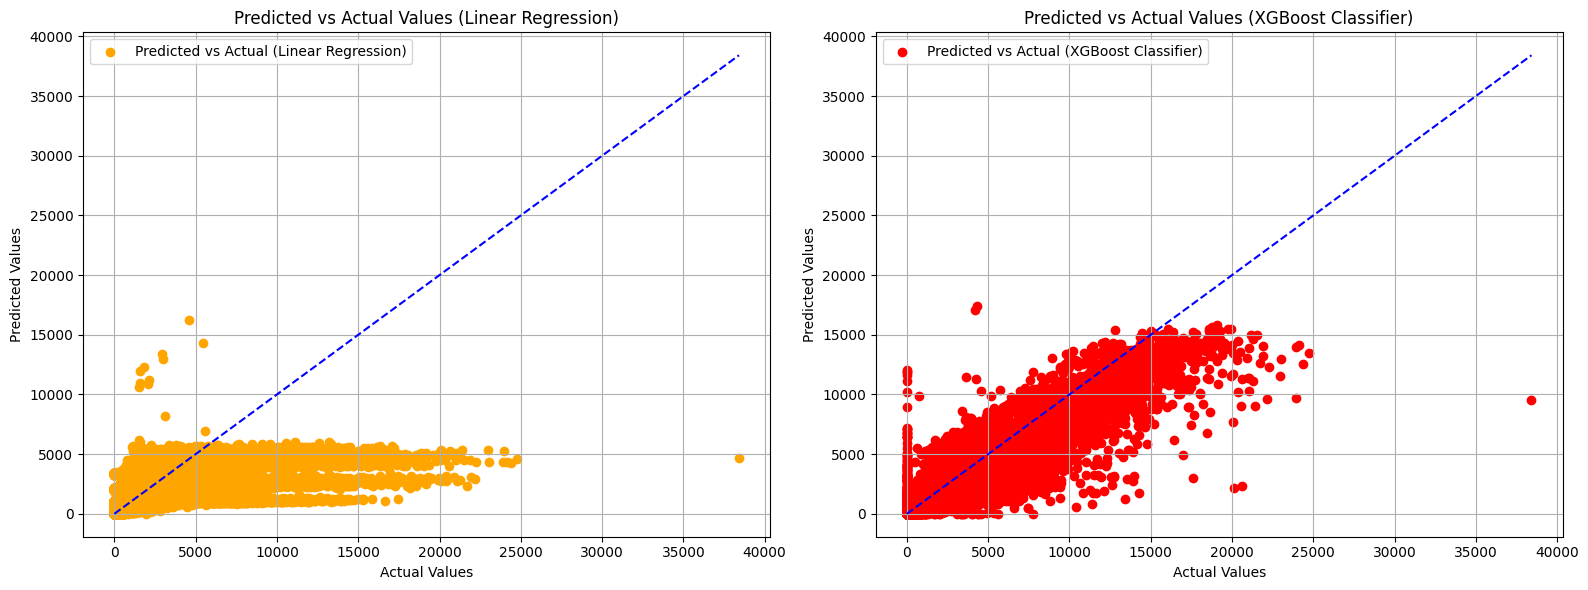

In [127]:
# Plotting Predicted values vs true 
X_test_ml.index = pd.to_datetime(X_test_ml.index)

# Create subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot for Linear Regression model
axs[0].scatter(y_test_ml, lr_predictions, color='orange', label='Predicted vs Actual (Linear Regression)')
axs[0].plot([0, np.max(y_test_ml)], [0, np.max(y_test_ml)], color='blue', linestyle='--')  # Diagonal line for reference
axs[0].set_xlabel('Actual Values')
axs[0].set_ylabel('Predicted Values')
axs[0].set_title('Predicted vs Actual Values (Linear Regression)')
axs[0].legend()
axs[0].grid(True)

# Scatter plot for XGBoost Classifier model
axs[1].scatter(y_test_ml, xgb_predictions, color='red', label='Predicted vs Actual (XGBoost Classifier)')
axs[1].plot([0, np.max(y_test_ml)], [0, np.max(y_test_ml)], color='blue', linestyle='--')  # Diagonal line for reference
axs[1].set_xlabel('Actual Values')
axs[1].set_ylabel('Predicted Values')
axs[1].set_title('Predicted vs Actual Values (XGBoost Classifier)')
axs[1].legend()
axs[1].grid(True)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


### Feature Importance

In [128]:
# Get feature importance
feature_importance = model_xgb.feature_importances_

# Access column names from the preprocessor step in the pipeline
column_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Create a DataFrame to store feature importance
feature_importance_df = pd.DataFrame({'Feature': column_names, 'Importance': feature_importance})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

feature_importance_df.head(55)

,Feature,Importance
18,cat__family_GROCERY I,0.416785
9,cat__family_BEVERAGES,0.162325
13,cat__family_CLEANING,0.074461
36,cat__family_PRODUCE,0.060414
14,cat__family_DAIRY,0.057601
11,cat__family_BREAD/BAKERY,0.037144
0,num__store_nbr,0.027435
34,cat__family_POULTRY,0.026200
1,num__onpromotion,0.023898
30,cat__family_MEATS,0.021333


### Hyperparameter Tuning

- Since XGB Regressor is our best performing model, we will fine-tune its hyperparameters to try and get better performance out of it.
- We will employ RandomizedGridSearch for our hyperparameter tuning.

In [129]:
# Define the parameter grid
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [0.3, 0.5, 0.7],
    'gamma': [0, 0.1, 0.2],
    'alpha': [0, 0.1, 0.2],
    'lambda': [0, 0.1, 0.2]
}

# Initialize the XGBRegressor
xgb = XGBRegressor()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist,
    cv=3,
    random_state=0
)

# Fit RandomizedSearchCV
random_search.fit(X_train_processed, y_train_ml)

# Get the best parameters found
best_params = random_search.best_params_

# Initialize XGBRegressor with the best parameters
best_xgb_model = XGBRegressor(**best_params)

# Fit the model to the training data
best_xgb_model.fit(X_train_processed, y_train_ml)

# Print the best parameters found
print("Best parameters:", best_params)


Best parameters: {'subsample': 0.7, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.05, 'lambda': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.3, 'alpha': 0.2}


In [130]:
# Define and train XGBoost model with the best parameters
best_xgb_model = XGBRegressor(**best_params)  # Initialize XGBoost model with best parameters
best_xgb_model.fit(X_train_processed, y_train_ml)  # Train the model

# Predict using the XGBoost model
predictions_xgb = best_xgb_model.predict(X_test_processed)
predictions_xgb_no_negative = np.maximum(predictions_xgb, 0)  # Ensure no negative values in predictions

# Compute Mean Absolute Error (MAE)
new_mae_xgb = mean_absolute_error(y_test_ml, predictions_xgb_no_negative)

# Compute Root Mean Squared Logarithmic Error (RMSLE)
new_rmsle_xgb = np.sqrt(mean_squared_error(np.log1p(y_test_ml), np.log1p(predictions_xgb_no_negative)))

# Compute Root Mean Squared Error (RMSE)
new_rmse_xgb = np.sqrt(mean_squared_error(y_test_ml, predictions_xgb_no_negative))

# Print evaluation metrics
print("XGBoost Model:")
print("Mean Absolute Error (MAE):", new_mae_xgb)
print("Root Mean Squared Logarithmic Error (RMSLE):", new_rmsle_xgb)
print("Root Mean Squared Error (RMSE):", new_rmse_xgb)


XGBoost Model:
Mean Absolute Error (MAE): 253.2234745838092
Root Mean Squared Logarithmic Error (RMSLE): 1.8314519958696245
Root Mean Squared Error (RMSE): 674.7397403669586


In [131]:
# Define performance metrics before tuning
metrics_before_tuning = {
    'Model': ['XGBoost Regressor (Before Tuning)'],
    'MAE': [xgb_mae],
    'RMSLE': [xgb_rmsle],
    'RMSE': [xgb_rmse]
}

# Define performance metrics after tuning
metrics_after_tuning = {
    'Model': ['XGBoost Regressor (After Tuning)'],
    'MAE': [new_mae_xgb],
    'RMSLE': [new_rmsle_xgb],
    'RMSE': [new_rmse_xgb]
}

# Create DataFrames
df_before_tuning = pd.DataFrame(metrics_before_tuning)
df_after_tuning = pd.DataFrame(metrics_after_tuning)

# Concatenate DataFrames for comparison
metrics_df = pd.concat([df_before_tuning, df_after_tuning], ignore_index=True)

print("Comparison Before and After Tuning for XGBoost Regressor:")
print(metrics_df)


Comparison Before and After Tuning for XGBoost Regressor:
                               Model         MAE     RMSLE        RMSE
0  XGBoost Regressor (Before Tuning)  125.965558  1.510552  404.470544
1   XGBoost Regressor (After Tuning)  253.223475  1.831452  674.739740


- The model is performing  better before tuning, Hence we will drop the tuned model

### Test data

In [132]:
# load the test data

test_data = pd.read_csv(r'C:\Users\HP\OneDrive\Desktop\Github projects\Time-Series-Regression-Analysis\datasets\test - in.csv',parse_dates = ['date'])
test_data.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [133]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           28512 non-null  int64         
 1   date         28512 non-null  datetime64[ns]
 2   store_nbr    28512 non-null  int64         
 3   family       28512 non-null  object        
 4   onpromotion  28512 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 1.1+ MB


In [134]:
# Drop ID column

test_data.drop('id', axis=1, inplace=True)

In [135]:
# Aggregare train data
test_aggregated = test_data.groupby(['date', 'family', 'store_nbr']).agg({'onpromotion' : 'sum'}).reset_index()
test_aggregated.tail(3)

,date,family,store_nbr,onpromotion
28509,2017-08-31,SEAFOOD,52,1
28510,2017-08-31,SEAFOOD,53,0
28511,2017-08-31,SEAFOOD,54,0


In [136]:
# Engineering Features
# Get month
test_aggregated['month'] = test_aggregated['date'].dt.month

# Get day
test_aggregated['dayofweek'] = test_aggregated['date'].dt.day

# Get weekend

test_aggregated['weekend'] = np.where(test_aggregated['dayofweek'].isin(['Saturday', 'Sunday']), 'Yes', 'No')

# Get quarter
test_aggregated['quarter'] = test_aggregated['date'].dt.quarter

# Get week
test_aggregated['Week'] = test_aggregated['date'].dt.isocalendar().week

 # Get Pay data: 15th of the month and last day of the month
test_aggregated['is_payday'] = np.where((test_aggregated['date'].dt.day == 15) | (test_aggregated['date'].dt.is_month_end), 'Yes', 'No')

test_aggregated.head()



,date,family,store_nbr,onpromotion,month,dayofweek,weekend,quarter,Week,is_payday
0,2017-08-16,AUTOMOTIVE,1,0,8,16,No,3,33,No
1,2017-08-16,AUTOMOTIVE,2,0,8,16,No,3,33,No
2,2017-08-16,AUTOMOTIVE,3,0,8,16,No,3,33,No
3,2017-08-16,AUTOMOTIVE,4,0,8,16,No,3,33,No
4,2017-08-16,AUTOMOTIVE,5,0,8,16,No,3,33,No


In [137]:
test_aggregated.isna().sum()

date           0
family         0
store_nbr      0
onpromotion    0
month          0
dayofweek      0
weekend        0
quarter        0
Week           0
is_payday      0
dtype: int64

In [138]:
# set date as the index

test_aggregated.set_index('date', inplace=True)

test_aggregated.head()

,family,store_nbr,onpromotion,month,dayofweek,weekend,quarter,Week,is_payday
date,,,,,,,,,
2017-08-16,AUTOMOTIVE,1,0,8,16,No,3,33,No
2017-08-16,AUTOMOTIVE,2,0,8,16,No,3,33,No
2017-08-16,AUTOMOTIVE,3,0,8,16,No,3,33,No
2017-08-16,AUTOMOTIVE,4,0,8,16,No,3,33,No
2017-08-16,AUTOMOTIVE,5,0,8,16,No,3,33,No


In [139]:
test_aggregated.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28512 entries, 2017-08-16 to 2017-08-31
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   family       28512 non-null  object
 1   store_nbr    28512 non-null  int64 
 2   onpromotion  28512 non-null  int64 
 3   month        28512 non-null  int32 
 4   dayofweek    28512 non-null  int32 
 5   weekend      28512 non-null  object
 6   quarter      28512 non-null  int32 
 7   Week         28512 non-null  UInt32
 8   is_payday    28512 non-null  object
dtypes: UInt32(1), int32(3), int64(2), object(3)
memory usage: 1.8+ MB
